## Import

In [147]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join

%matplotlib inline

## Files

In [148]:
data_dirs = ["../data/post_scrape_cleanup/raw/", "../data/post_scrape_cleanup/processed/"]
file_lists = []
for i in range(len(data_dirs)):
    file_lists.append([(data_dirs[i] + f) for f in listdir(data_dirs[i]) if isfile(join(data_dirs[i], f))])
    """
    print("Data files in {}:".format(data_dirs[i]))
    print("--------")
    print([j for j in file_lists[i]])
    if i != len(data_dirs) - 1:
        print("\n"*1)
    """

## Making initial dataframes
There are 2 sets of data for each of the 26 heroes (a total of 52 distinct datasets). However, it's important to note that these datasets have already undergone preprocessing during scraping. Specifically, some features which were improperly calculated or deemed irrelevant were omitted from the dataset in an attempt to both improve accuracy and decrease feature noise. Additionally, these datasets were again processed after scraping to remove any entries which
    * have an incorrect featureset (due to bugs during scraping), and
    * are dupicates.
The scraper and post-scrape processing files can be found in `../scrape/` and `../post_scrape_cleanup/`, respectively.

The rawest dataset of the two contains information in it's original state (again, with some features removed) from PlayOverwatch. PlayOverwatch maintains hero-specific feature averages per Season, but the averages are not displayed/calculated correctly. However, PlayOverwatch does give the running sum of each of these features. This dataset is solely comprised of these running sums.

Using the running sums provided, per life and per second averages can be calculated using the deaths and time played features. The second dataset is a flavor of the original with the running sum features removed. These features are replaced with per second, per life, and per game averages.

---

The below map contains both datasets. This map contains keys for each dataset, where the respective value is another map. This inner map uses hero names as keys and the value is the Pandas dataframe.

In [149]:
db_data = {}
#For each dataset
for i in range(len(data_dirs)):
    #Get top level key
    top_key = data_dirs[i].split("/")
    top_key = top_key[len(top_key) - 2]
    db_data[top_key] = {}
    #Get hero data
    for j in range(len(file_lists[i])):
        #Hero key
        hero_key = (file_lists[i][j][ file_lists[i][j].rfind("/")+1:])[:-4]
        #Create dataframe
        db_data[top_key][hero_key] = pd.read_csv(file_lists[i][j])

### Observing the data
Below is a small sample of the processed Tracer data.

Keep in mind the goal is to identify a player's SR rank to be one of the following 7 classes:
* Bronze
* Silver
* Gold
* Platinum
* Diamond
* Master
* Grandmaster

Lets look at a sample of Bronze Tracers and compare them to GM Tracers. Specifically, let's look at Tracers an hour (3600 seconds) or more of play time in Season 8.

In [150]:
tracers = db_data["processed"]["tracer"]
tracers.head()

battletag    SR  all_damage_done_per_life  \
0  Fergalicious#21844  4037                889.211268   
1    PapaGlitchy#2651  2409                514.733333   
2          Wreck#1473  4172                  0.000000   
3        Jeremos#2358  3516               1135.654545   
4        EFFECT#31318  1958                994.953488   

   all_damage_done_per_second  average_life  barrier_damage_done_per_life  \
0                   17.537222     50.704225                    183.873239   
1                   11.698485     44.000000                    118.800000   
2                    0.000000     16.000000                      0.000000   
3                   17.350278     65.454545                      0.000000   
4                   16.205682     61.395349                    344.302326   

   barrier_damage_done_per_second  cards_per_game  critical_hit_accuracy  \
0                        3.626389             0.0                   0.09   
1                        2.700000             0.0                   0.10   
2                        0.000000             0.0                   0.00   
3                        0.000000             0.2                   0.07   
4                        5.607955             0.0                   0.05   

   critical_hits_per_life       ...        solo_kills_per_second  \
0               10.492958       ...                     0.003889   
1                7.200000       ...                     0.001515   
2                0.000000       ...                     0.000000   
3               13.090909       ...                     0.003333   
4                6.000000       ...                     0.004545   

   teleporter_pads_destroyed_per_life  teleporter_pads_destroyed_per_second  \
0                                 0.0                                   0.0   
1                                 0.0                                   0.0   
2                                 0.0                                   0.0   
3                                 0.0                                   0.0   
4                                 0.0                                   0.0   

   time_played_seconds  time_spent_on_fire_seconds_per_life  \
0                 3600                             5.098592   
1                  660                             3.533333   
2                   16                            11.000000   
3                 3600                             8.418182   
4                 2640                             1.767442   

   time_spent_on_fire_seconds_per_second  turrets_destroyed_per_life  \
0                               0.100556                    0.014085   
1                               0.080303                    0.000000   
2                               0.687500                    0.000000   
3                               0.128611                    0.036364   
4                               0.028788                    0.000000   

   turrets_destroyed_per_second  weapon_accuracy  win_percentage  
0                      0.000278             0.35            0.63  
1                      0.000000             0.23            0.29  
2                      0.000000             0.00            0.00  
3                      0.000556             0.41            0.33  
4                      0.000000             0.28            0.37  

[5 rows x 70 columns]

(Note: After feature distribution graphing that occurs later in this notebook, it appears that 2 *Tracer* players have extremely high `hero_to_barrier_damage_ratio` values: 2741 and 3917. These entries will be removed here.)

In [151]:
db_data["processed"]["tracer"] = db_data["processed"]["tracer"].drop([2741, 3917], axis=0)

From this point on, *valid* will be used to describe a player of a certain hero with a specified number of seconds playing on said hero. Data of interest should be assumed to be *valid* unless otherwise specified.

In [152]:
tracers = tracers[3600 <= tracers["time_played_seconds"]]
bronze_tracers = tracers[tracers["SR"] < 1500]
gm_tracers = tracers[4000 <= tracers["SR"]]

### Distribution
Observing the Tracer dataframe as a whole (tracers who've played 1 hour), we have the following distributions for *valid* and *all* Tracer players, respectively.

36085
7976


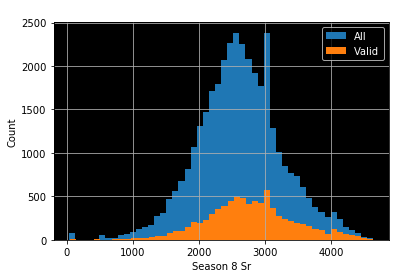

In [153]:
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams["text.color"] = "white"

def feature_to_title(feature_str):
    """
    Converts something_like_this, returning Something Like This
    """
    return feature_str.replace("_", " ").title()

def plot_hero_feature_distribution(hero_x_name, valid_criteria=3600, feature="SR"):
    """
    Plots the distribution of a specific fetaure for a specified hero. The valid
    criteria parameter is the time_played_seconds minimum value to be considered
    valid for Season 8. 3600s played means the valid graph will only have players
    who've played an hour or more on the specified hero.
    """
    #Get all hero x and all valid hero x entries
    all_hero_x = db_data["processed"][hero_x_name]
    valid_hero_x = all_hero_x[valid_criteria <= all_hero_x["time_played_seconds"]][feature]
    #Lists for graph enumeration
    hero_x_dfs = [all_hero_x[feature], valid_hero_x]
    hero_x_titles = [
        "All {}".format(hero_x_name.title()),
        "{}s w/ {}+ seconds".format(hero_x_name.title(), valid_criteria)
    ]
    hero_x_labels = ["All", "Valid"]
    #Print out data counts
    for i in range(len(hero_x_titles)):
        print(len(hero_x_dfs[i]))
    #Plot
    for i in range(len(hero_x_titles)):
        plt.hist(hero_x_dfs[i], bins=50, label=hero_x_labels[i])
        plt.xlabel("Season 8 {}".format(feature_to_title(feature)))
        plt.ylabel("Count")
        plt.title(hero_x_titles[i])
        plt.grid(True)
    plt.legend()
plot_hero_feature_distribution("tracer", valid_criteria=3600)

The graph above is shows  the SR distribution for *all* Tracer players and valid Tracer players, respectively.

Below is the total number of Tracer players in each rank.

In [154]:
valid_time = 14400

#SR map
sr_map = {
    "0_Bronze": [0, 1499],
    "1_Silver": [1500, 1999],
    "2_Gold": [2000, 2499],
    "3_Platinum": [2500, 2999],
    "4_Diamond": [3000, 3499],
    "5_Master": [3500, 3999],
    "6_Grandmaster": [4000, 5000]
}

#Returns the rank for a specified SR
def get_rank(sr):
    for rank in sr_map.keys():
        tup = sr_map[rank]
        if tup[0] <= sr <= tup[1]:
            return rank
        
#Counts the number of players in each rank for a specified hero
def hero_rank_counter(hero_name, valid_criteria=3600):
    """
    Counts the number of players in each rank for a specified hero.
    Returns a dictionary containing the counts.
    """
    hero_rank_map = {}
    for k in sr_map.keys():
        hero_rank_map[k] = 0
    hero_df = db_data["processed"][hero_name]
    hero_df = hero_df[valid_criteria <= hero_df["time_played_seconds"]]["SR"]
    for sr in hero_df:
        hero_rank_map[get_rank(sr)] += 1
    return hero_rank_map
hero_rank_count = hero_rank_counter("tracer", valid_criteria=7200)

def hero_target_counter(hero_name, target_df):
    """
    Counts the number of players in each rank for a specified hero, specifically
    for dataframes that have already been split into features and targets.
    """
    hero_target_map = {}
    for k in sr_map.keys():
        hero_target_map[k] = len(target_df[k == target_df["SR"]])
    return hero_target_map        

To observe the different distributions of feature values within the SR classes, the following function is available.

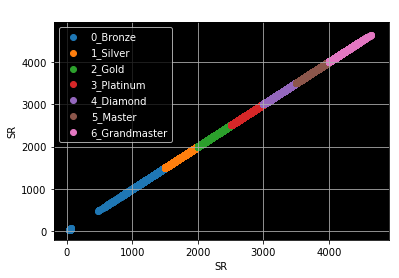

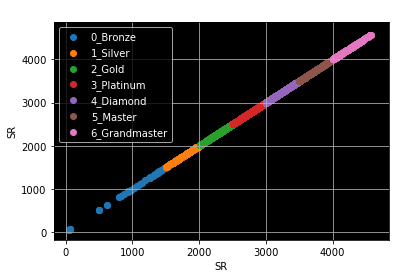

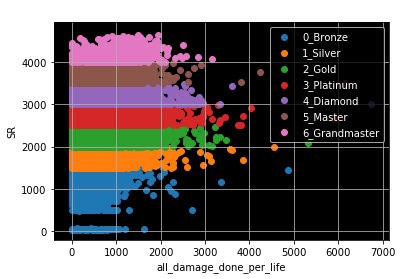

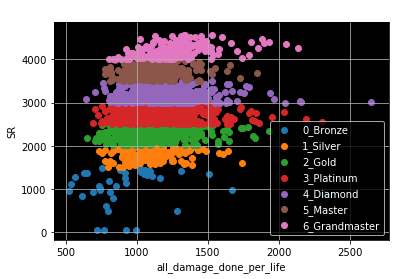

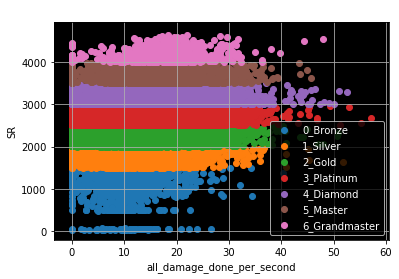

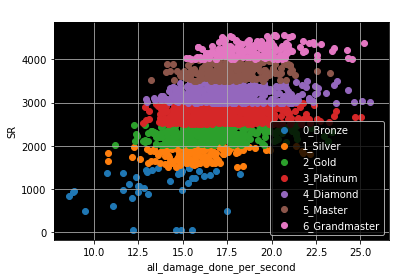

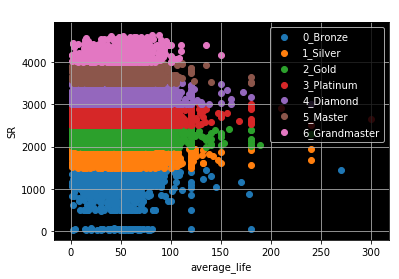

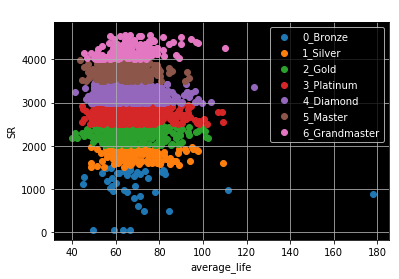

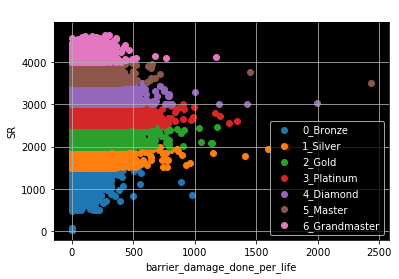

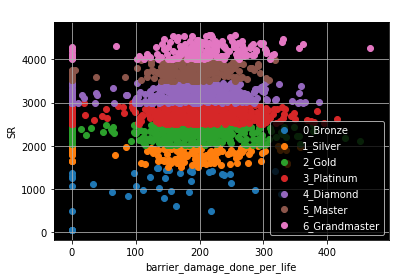

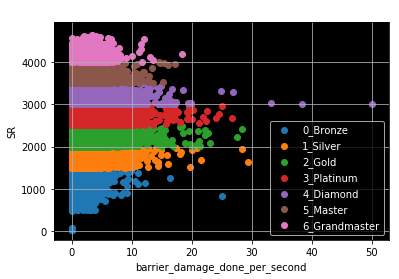

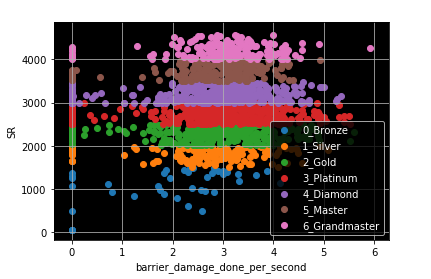

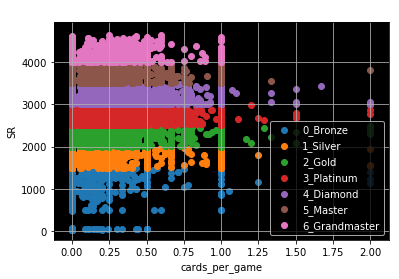

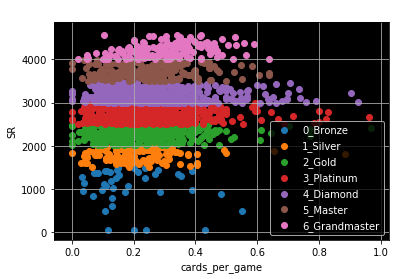

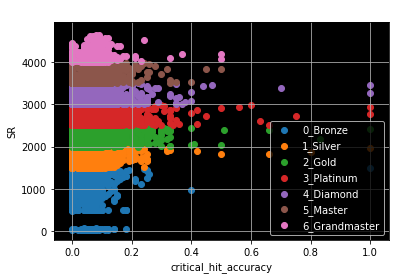

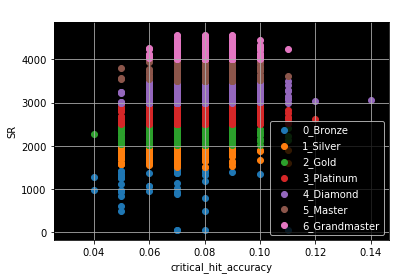

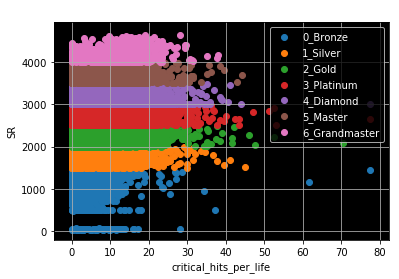

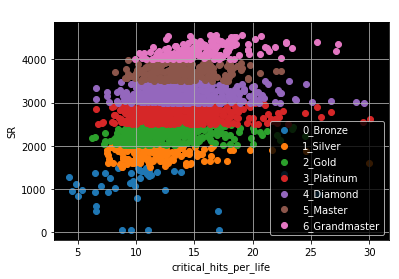

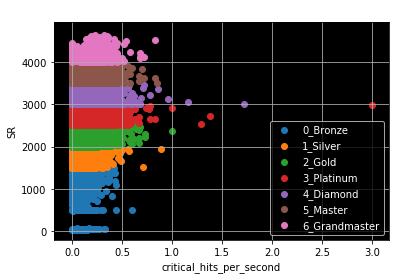

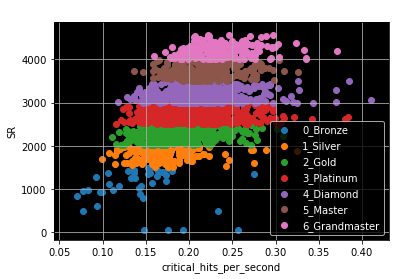

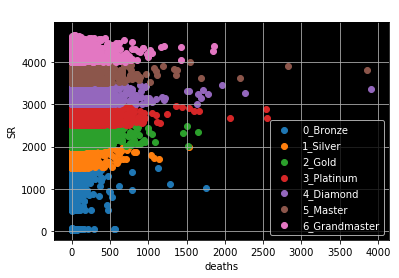

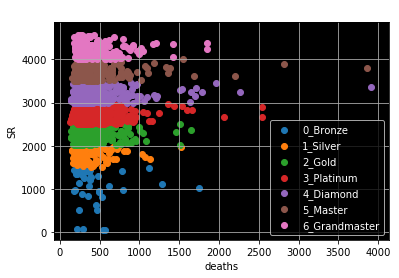

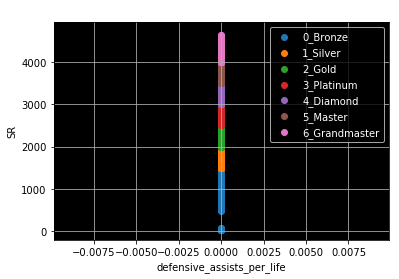

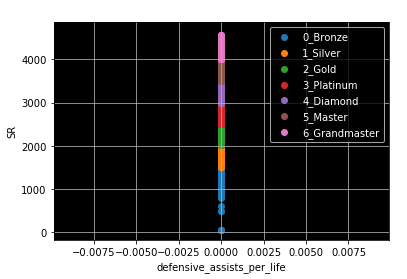

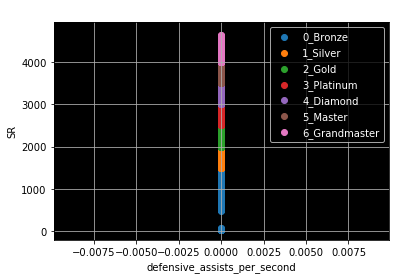

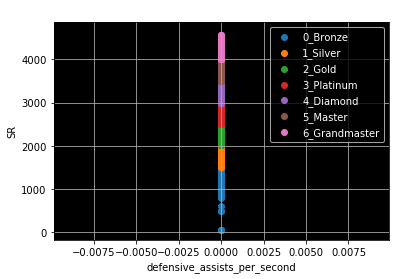

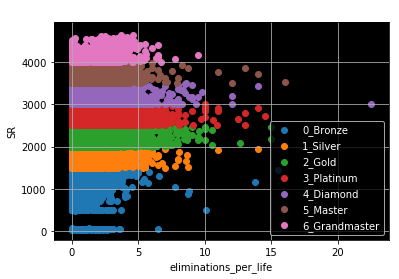

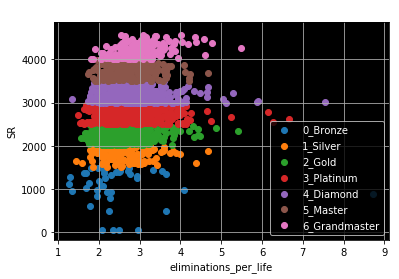

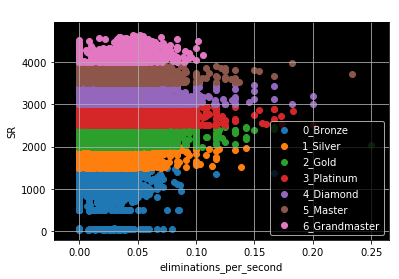

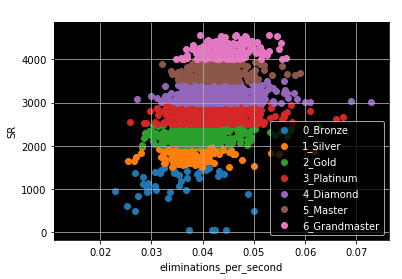

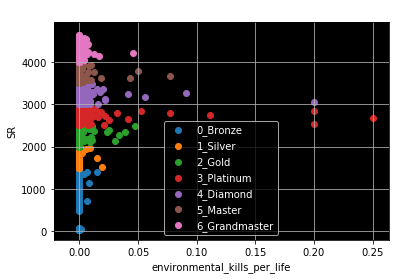

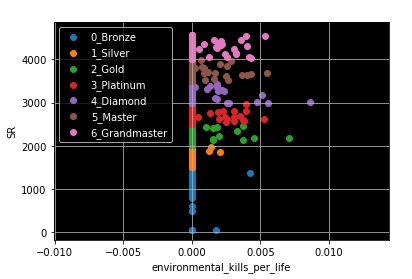

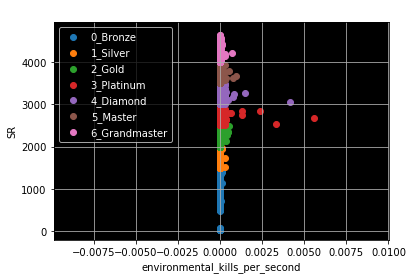

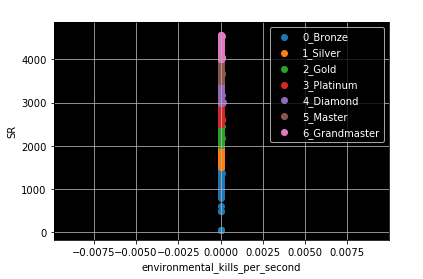

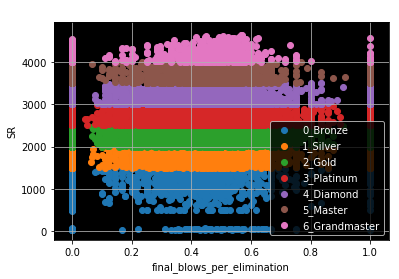

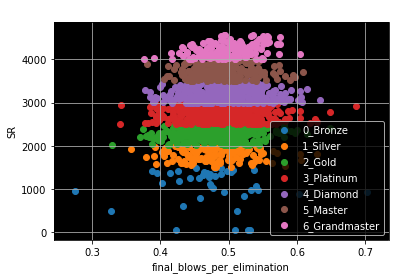

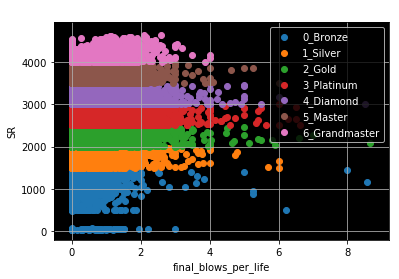

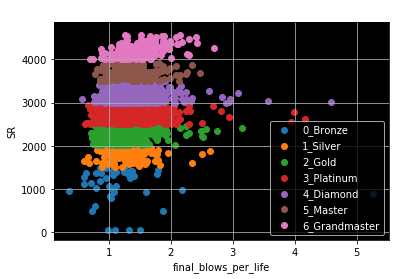

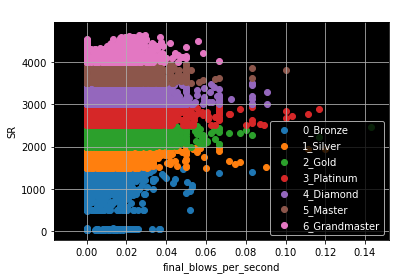

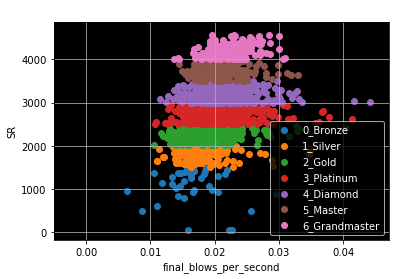

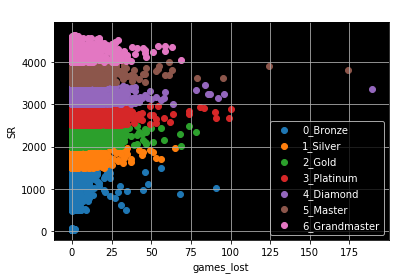

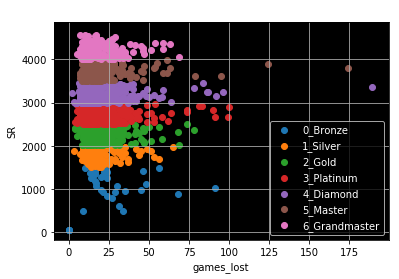

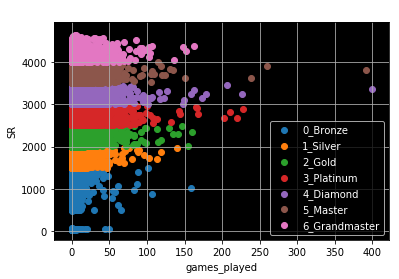

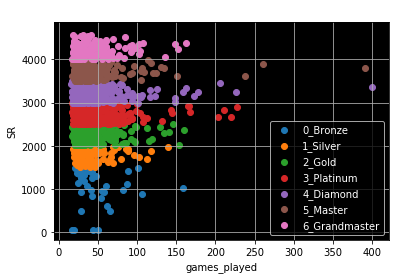

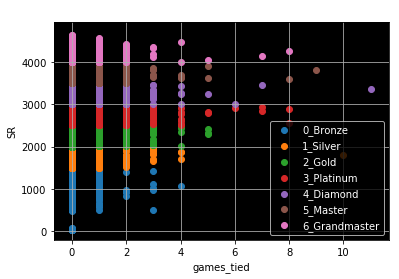

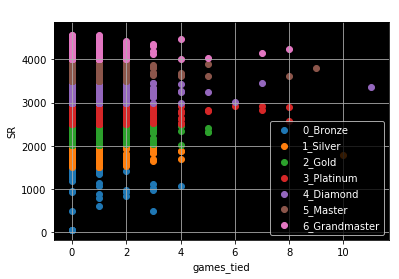

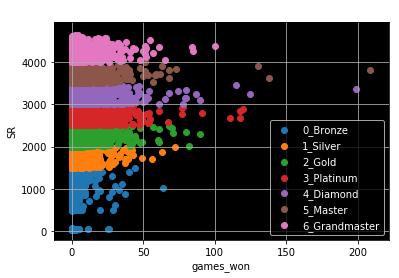

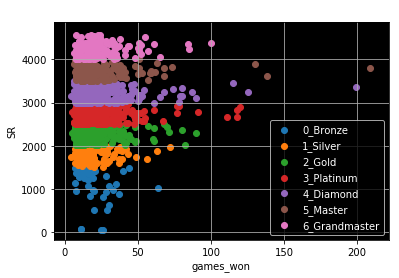

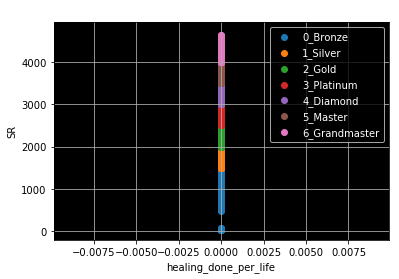

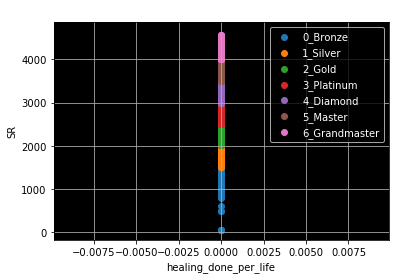

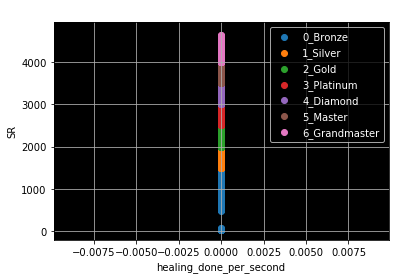

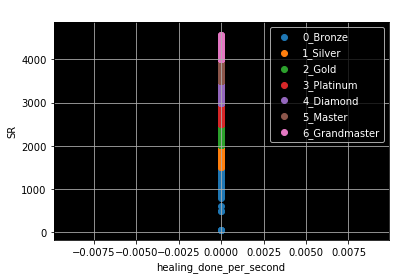

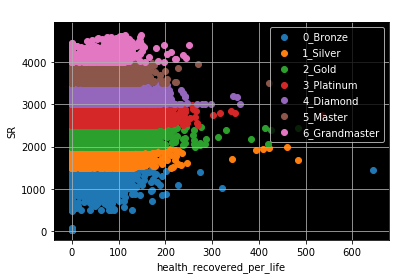

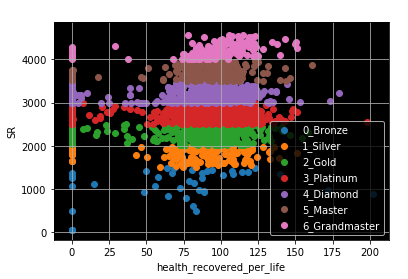

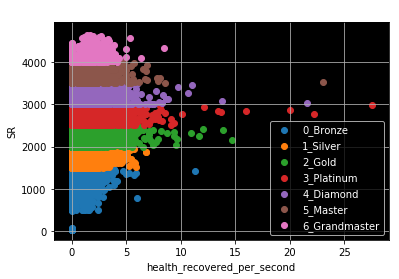

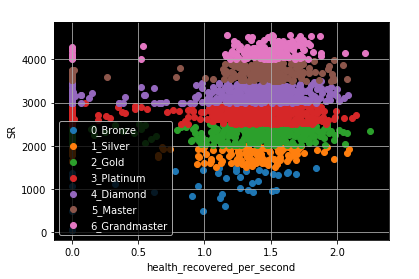

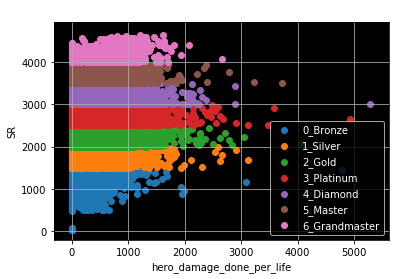

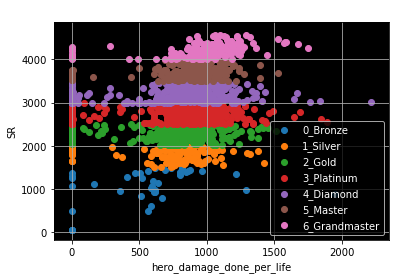

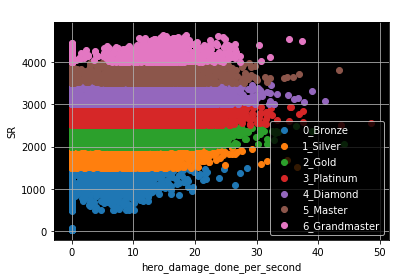

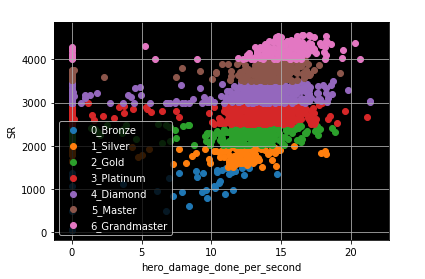

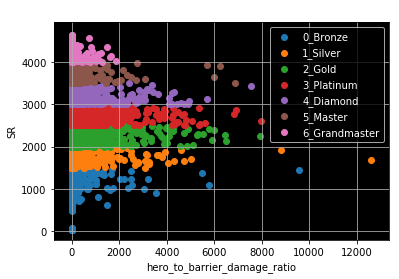

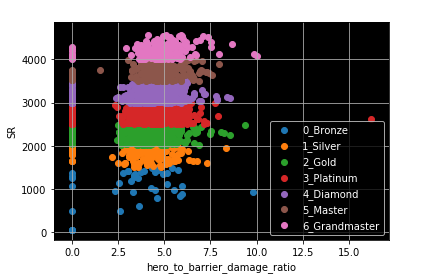

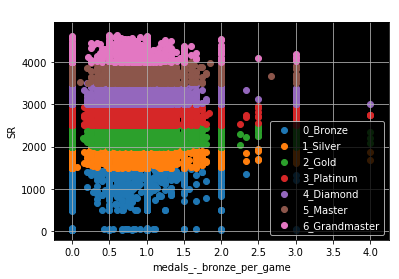

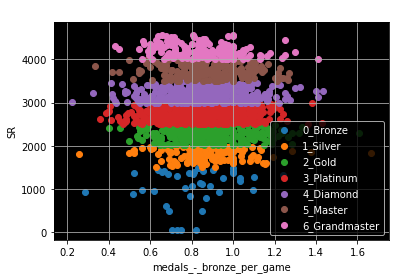

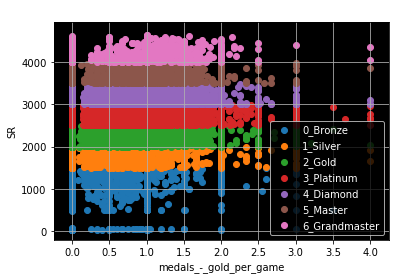

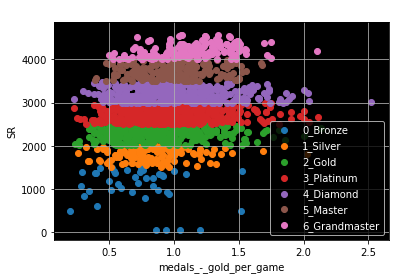

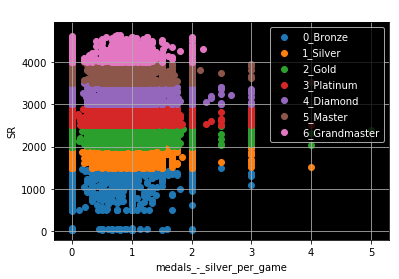

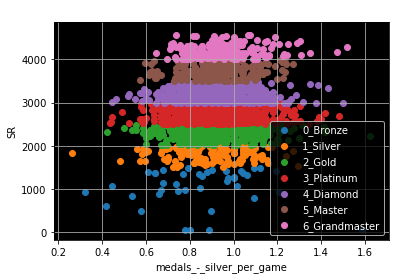

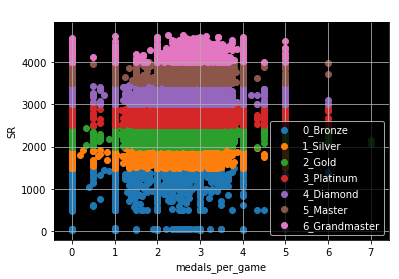

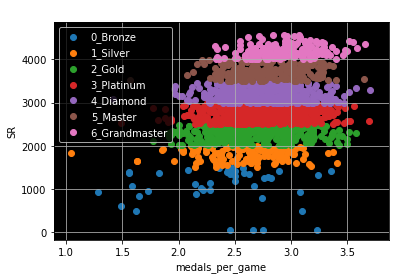

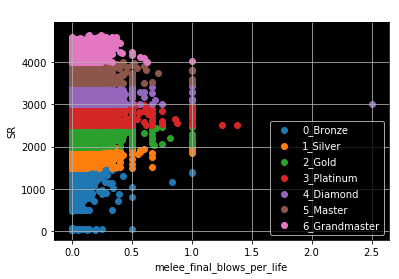

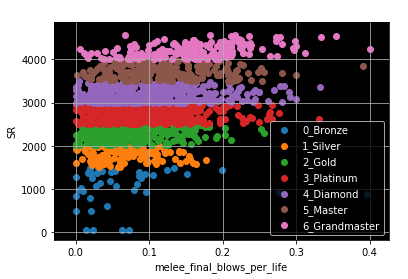

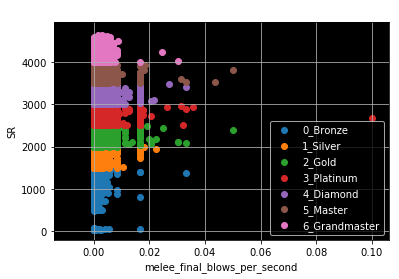

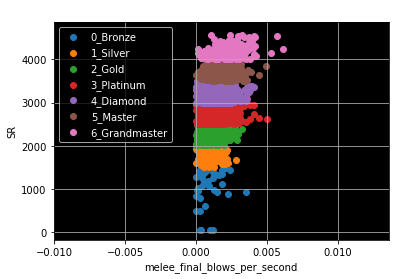

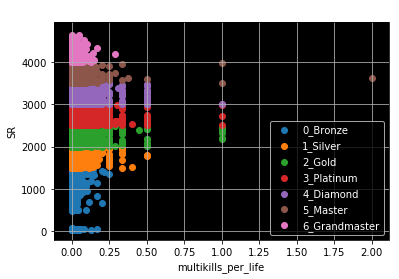

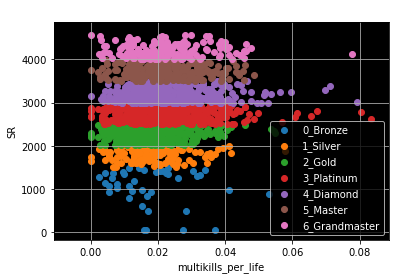

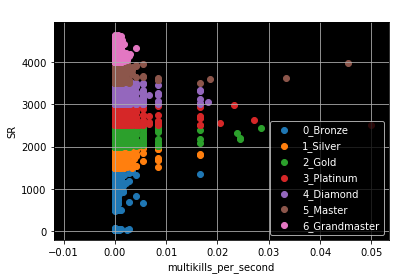

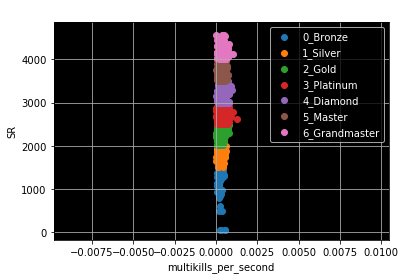

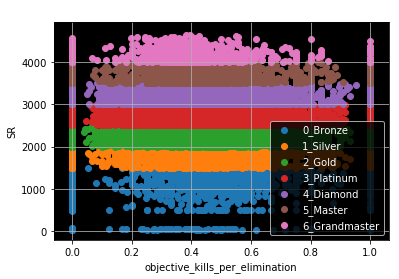

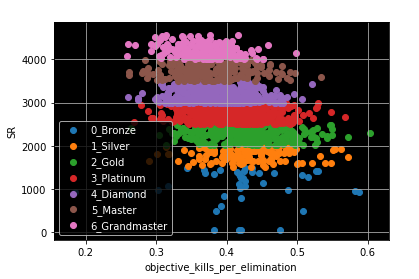

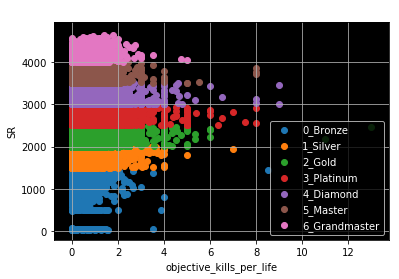

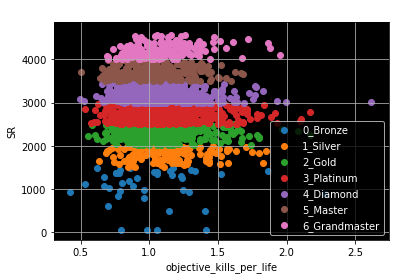

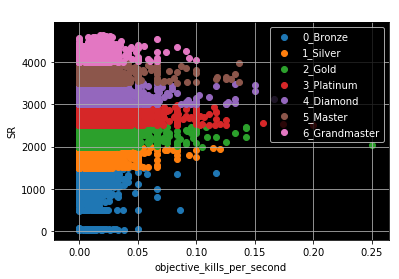

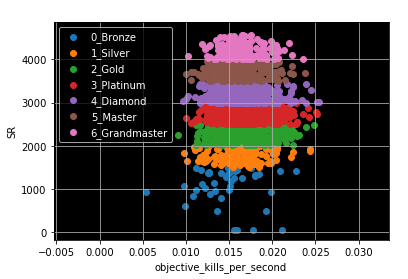

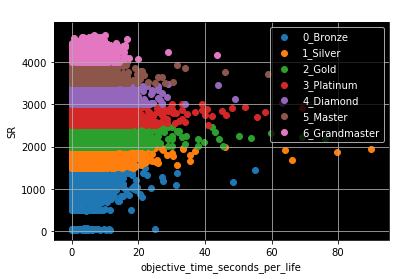

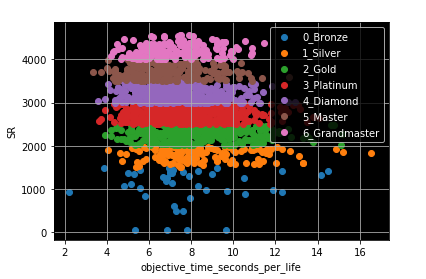

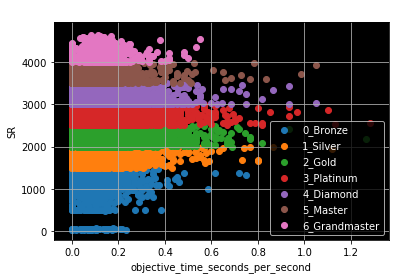

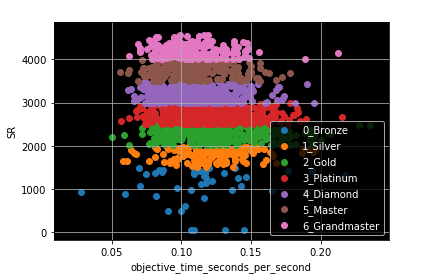

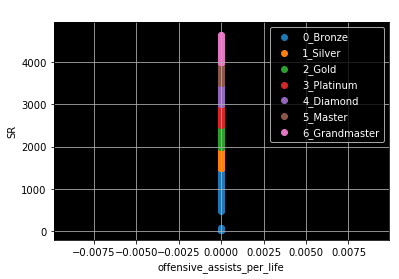

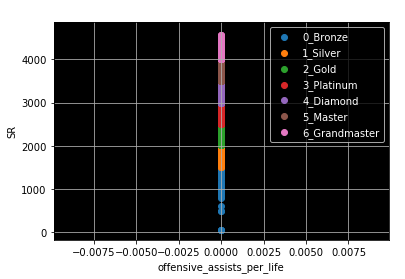

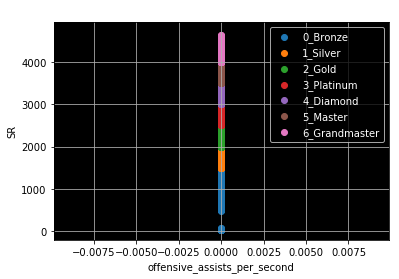

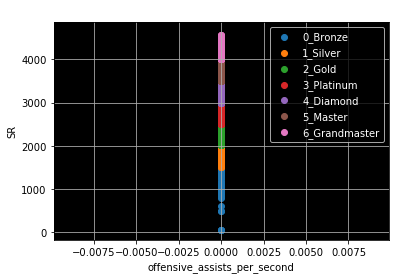

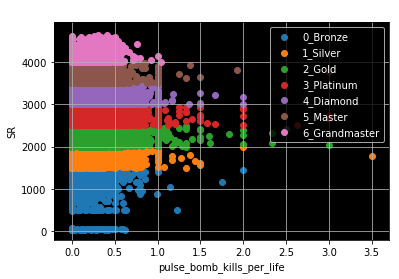

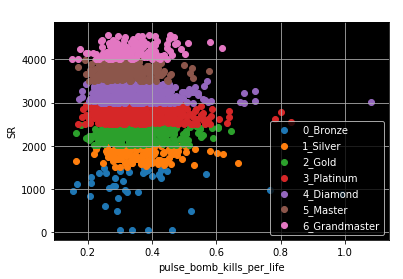

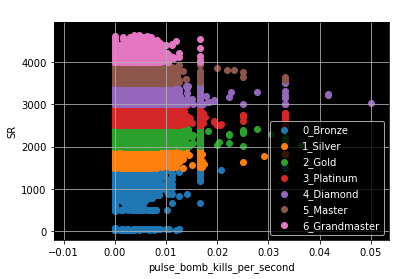

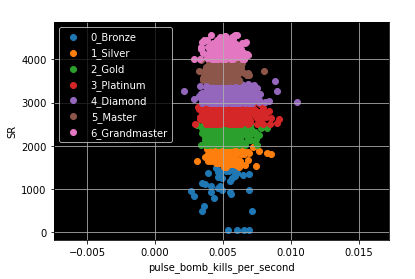

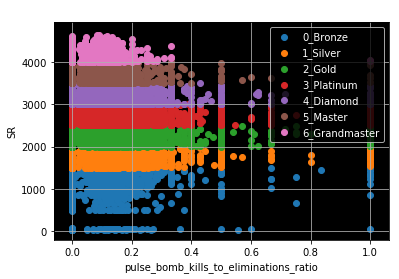

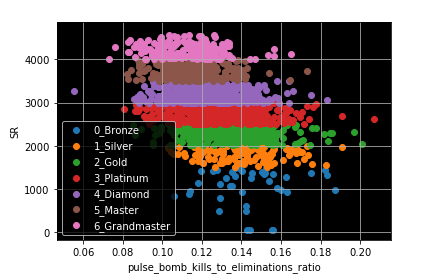

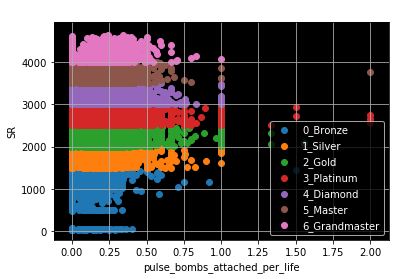

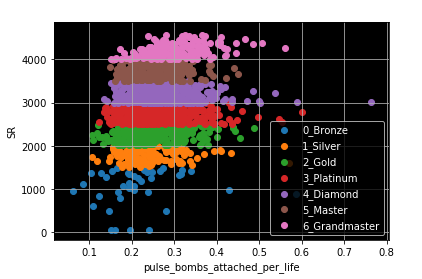

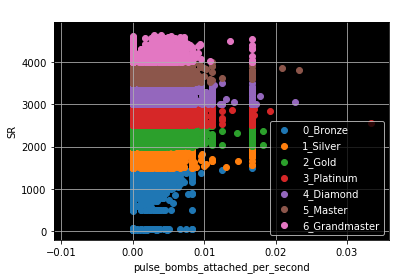

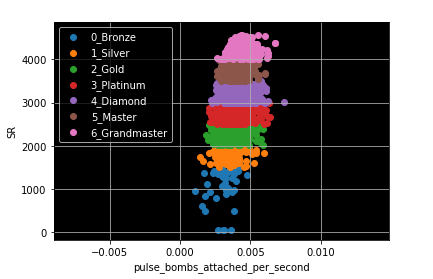

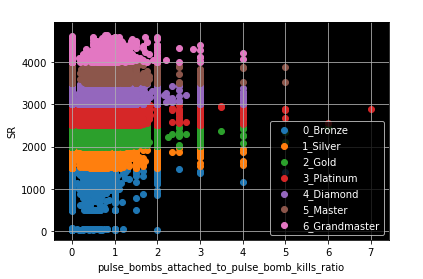

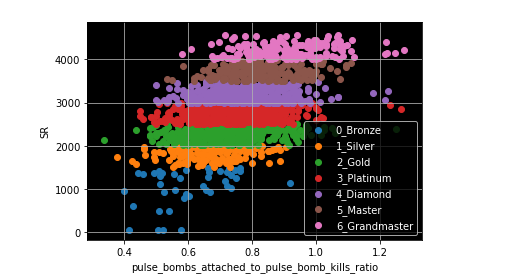

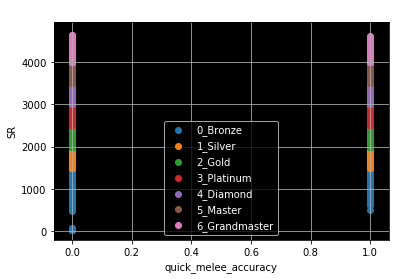

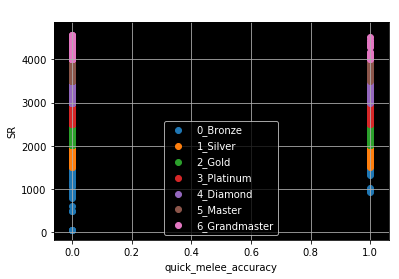

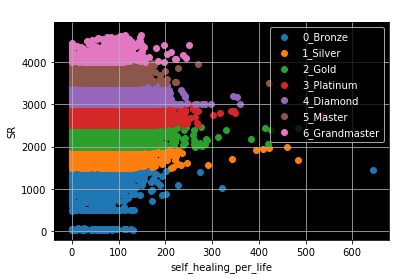

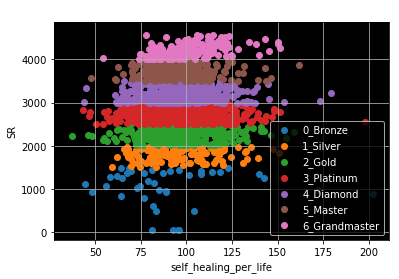

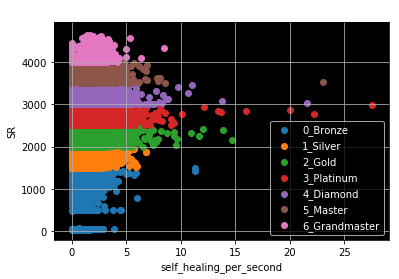

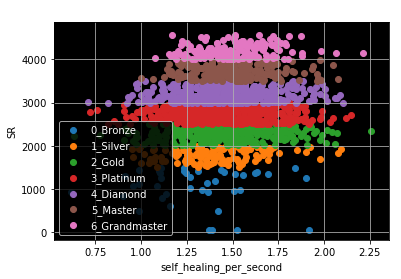

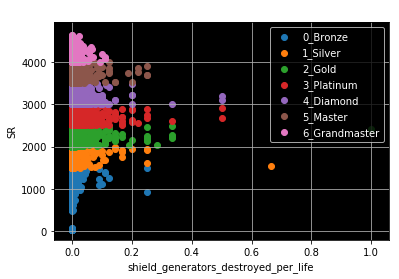

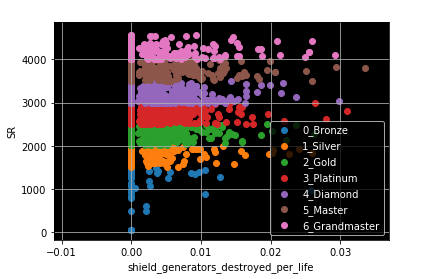

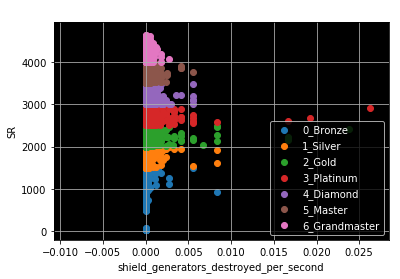

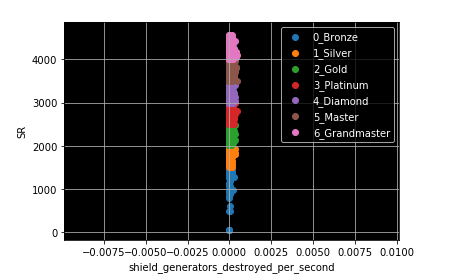

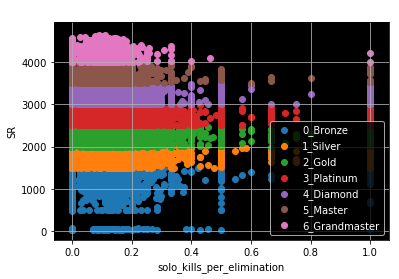

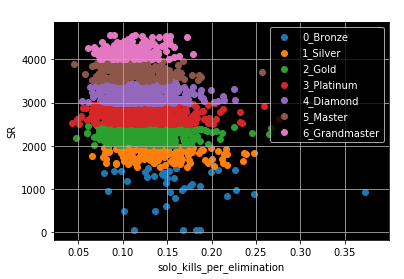

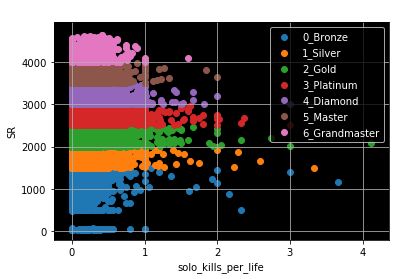

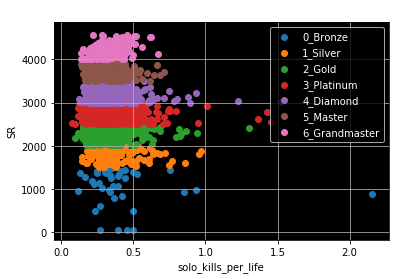

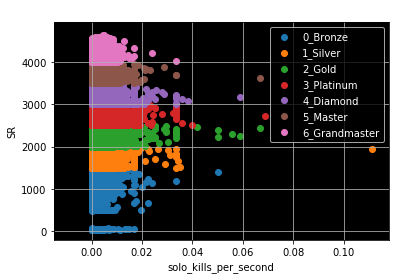

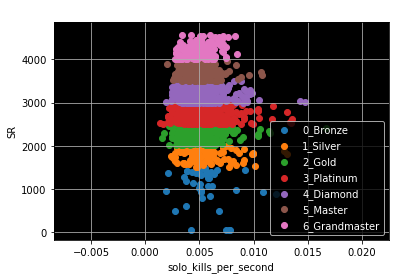

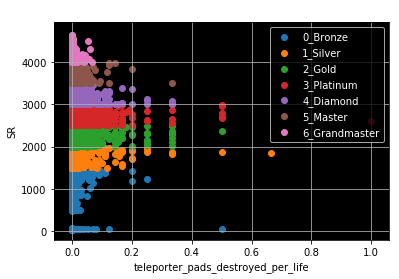

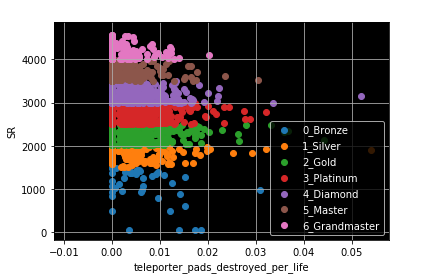

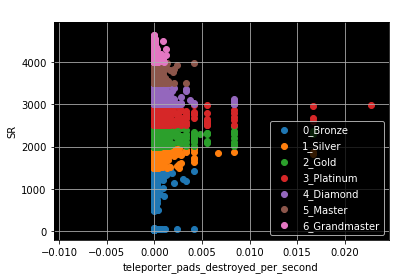

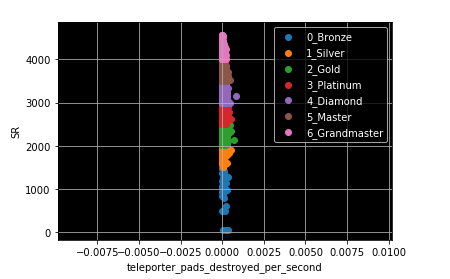

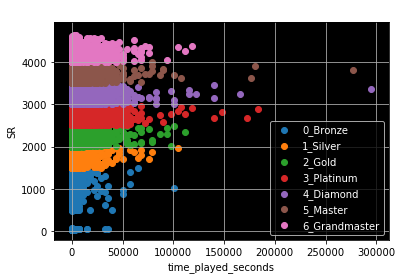

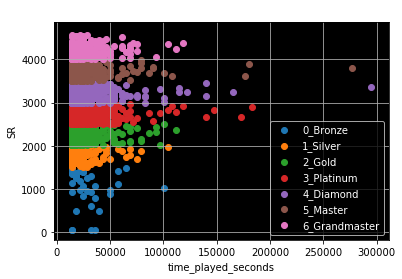

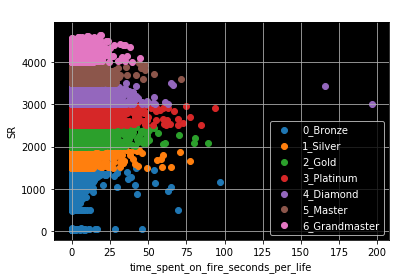

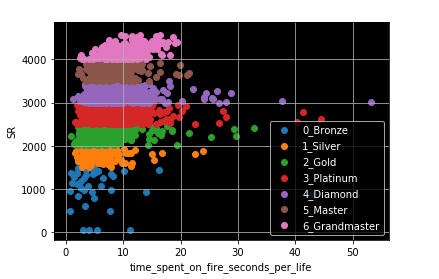

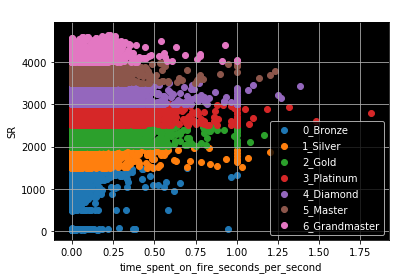

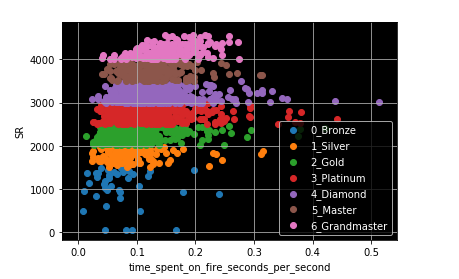

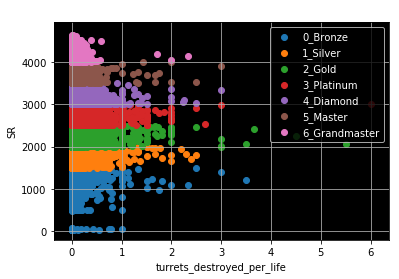

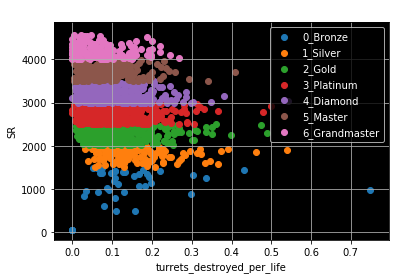

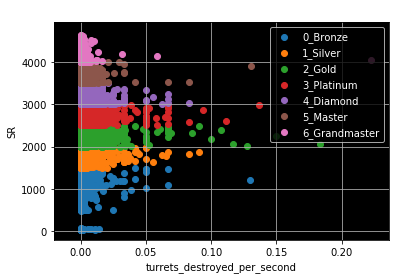

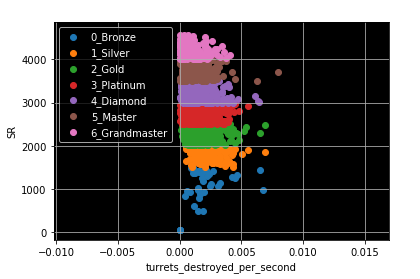

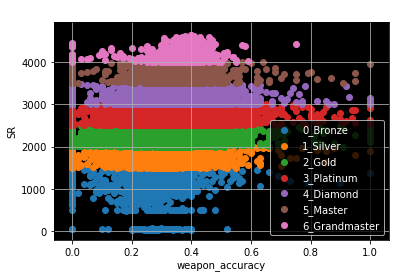

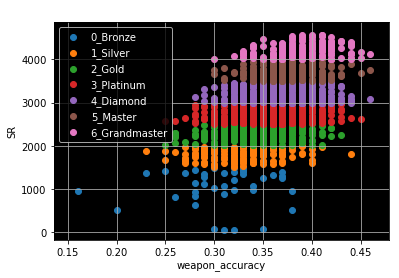

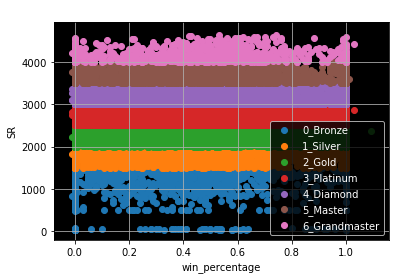

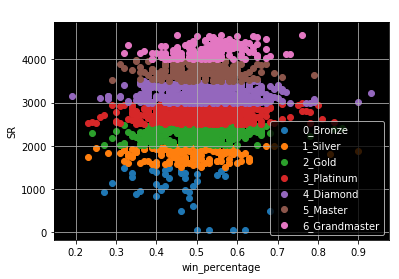

In [155]:
def plot_hero_sr_feature_distribution(hero_name, valid_criteria=3600, feature="SR", mode="hist"):
    """
    Plots the distributions of a specific fetaure for a specified hero within the SR
    classes. The valid criteria parameter is the time_played_seconds minimum value to
    be considered valid for Season 8. 3600s played means the valid graph will only
    have players who've played an hour or more on the specified hero.
    """
    #Sorted sr ranks
    sr_keys = [tup[0] for tup in sorted(sr_map.iteritems(), key=lambda (k,v): v)]
    #Get dataframe for each sr rank
    all_hero_sr_dfs = []
    valid_hero_sr_dfs = []
    all_hero = db_data["processed"][hero_name]
    #Iterate over ranks
    for i in range(len(sr_keys)):
        #Query lower bound
        sr_df = all_hero[sr_map[sr_keys[i]][0] <= all_hero["SR"]]
        #Query upper bound
        sr_df = sr_df[sr_df["SR"] <= sr_map[sr_keys[i]][1]]
        #Append all and valid dfs for specified sr
        #Histogram
        if mode == "hist":
            all_hero_sr_dfs.append(sr_df[feature])
            valid_hero_sr_dfs.append(sr_df[valid_criteria <= sr_df["time_played_seconds"]][feature])
        #Scatterplot
        elif mode == "scat":
            all_hero_sr_dfs.append(sr_df[[feature, "SR"]])
            valid_hero_sr_dfs.append(sr_df[valid_criteria <= sr_df["time_played_seconds"]][[feature, "SR"]])
    #List of all and valid distributions for each SR class
    l_sr = [all_hero_sr_dfs, valid_hero_sr_dfs]
    #List of titles
    l_titles = [
        "All {} {} by SR".format(hero_name.title(), feature_to_title(feature)),
        "{} {} w/ {}+ seconds by SR".format(hero_name.title(), feature_to_title(feature), valid_criteria)
    ]
    
    #Labels are SR keys
    #Plot
    #For each of [all, valid]
    for i in range(len(l_titles)):
        l = l_sr[i]
        #For each SR class [Bronze, Silver, ..., GM]
        #Note: Reducing bin size can make graphing faster
        for j in range(len(sr_keys)):
            if mode == "hist":
                plt.hist(l[j], bins=20, label=sr_keys[j])
            elif mode == "scat":
                plt.scatter(l[j][feature], l[j]["SR"], label=sr_keys[j])
        #Histogram labels
        if mode == "hist":
            plt.xlabel("Season 8 {}".format(feature_to_title(feature)))
            plt.ylabel("Count")
        #Scatter labels
        elif mode == "scat":
            plt.xlabel(feature)
            plt.ylabel("SR")
        plt.title(l_titles[i])
        plt.grid(True)
        plt.legend()
        plt.show()

#Get all tracer features
fs = list(db_data["processed"]["tracer"].columns.values)
#Remove non-numeric
fs.remove("battletag")
#Graph each
for k in fs:
    plot_hero_sr_feature_distribution("tracer", valid_criteria=valid_time, feature=k, mode="scat")

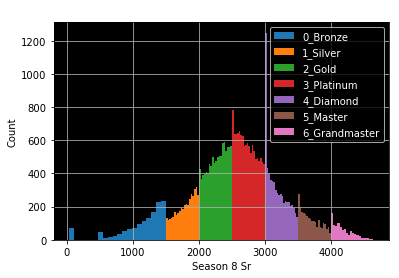

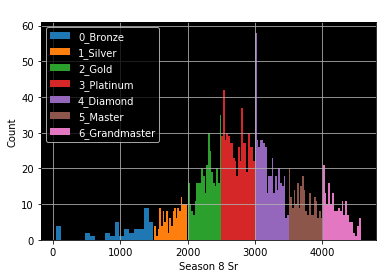

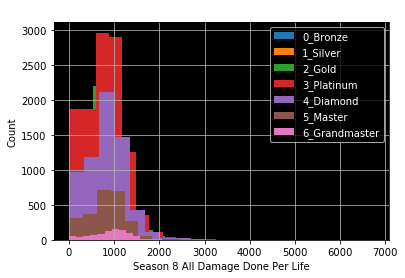

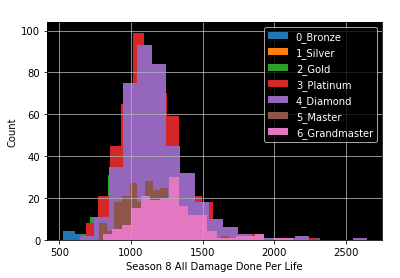

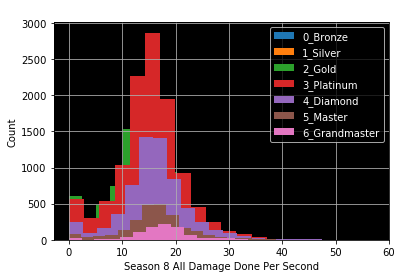

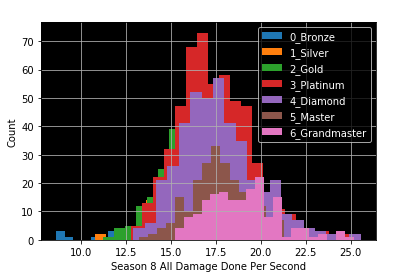

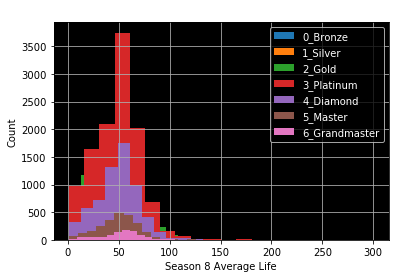

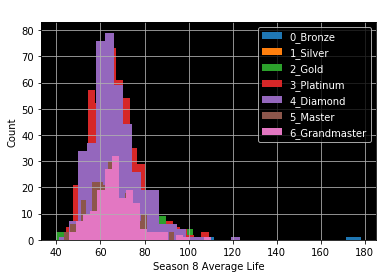

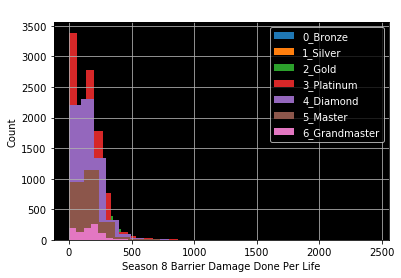

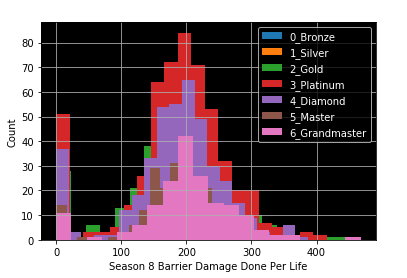

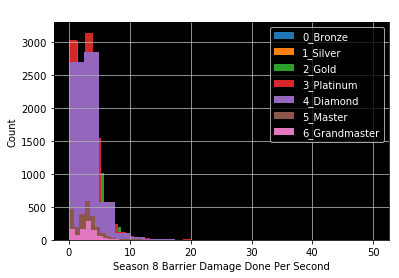

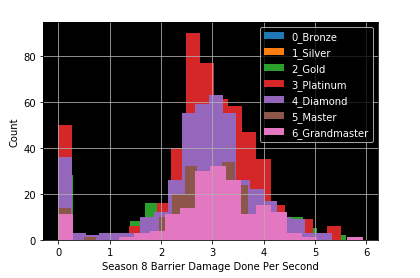

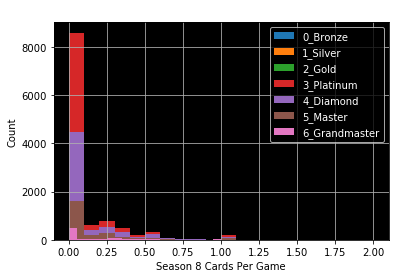

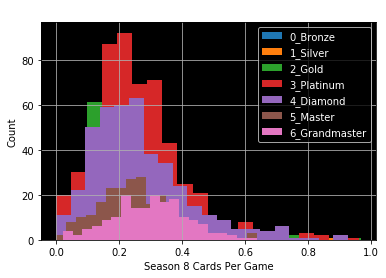

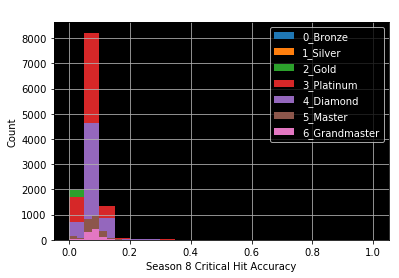

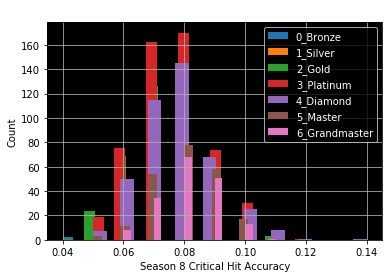

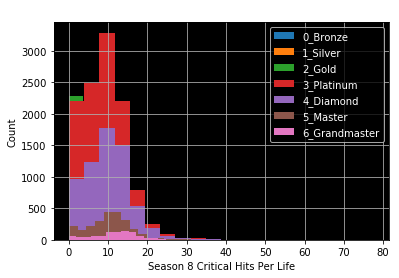

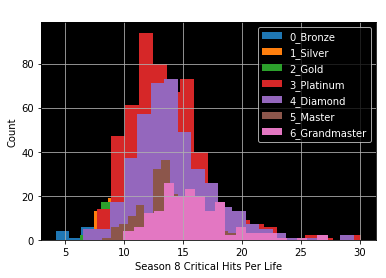

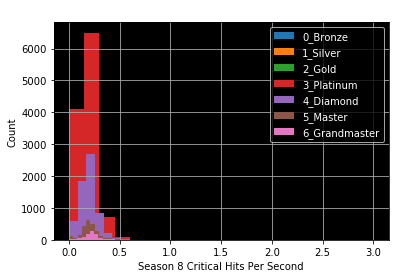

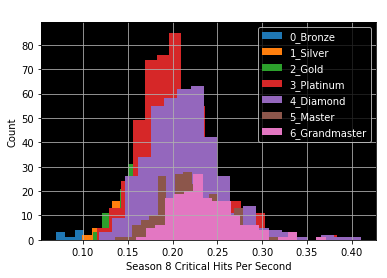

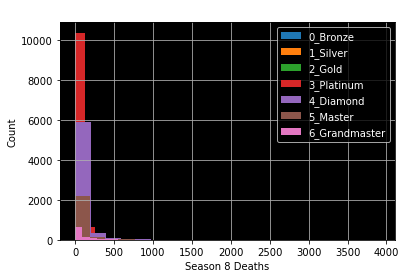

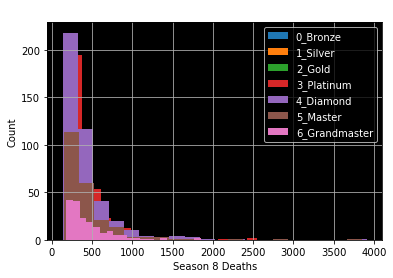

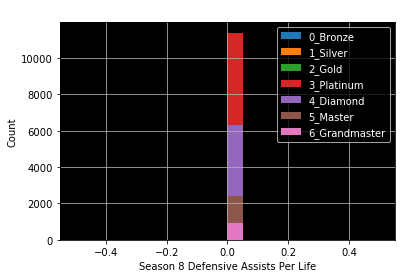

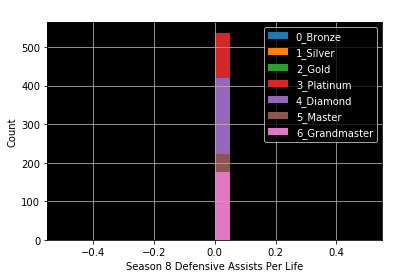

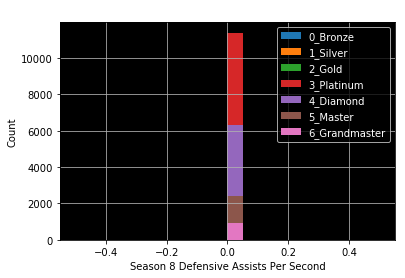

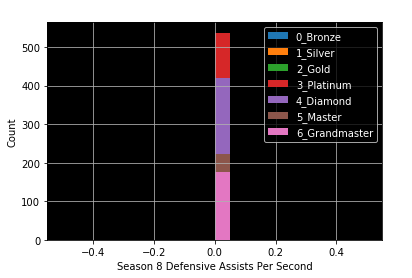

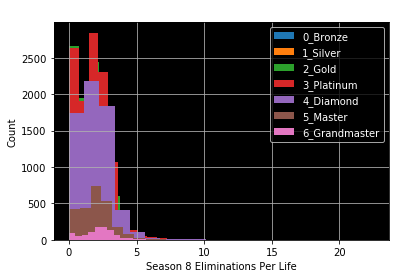

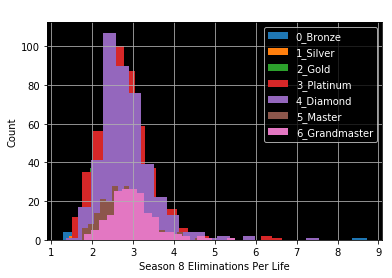

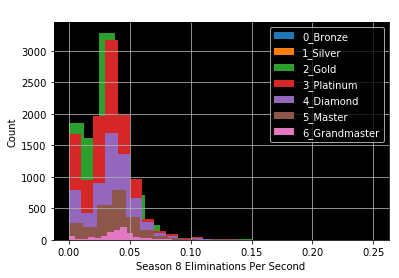

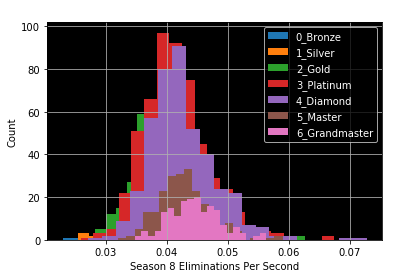

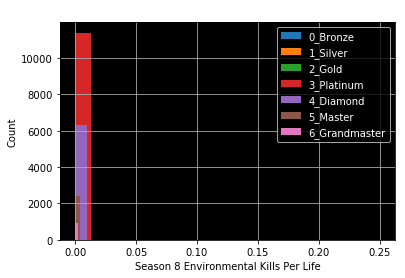

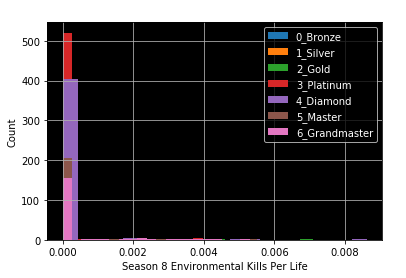

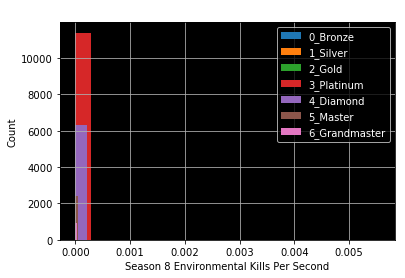

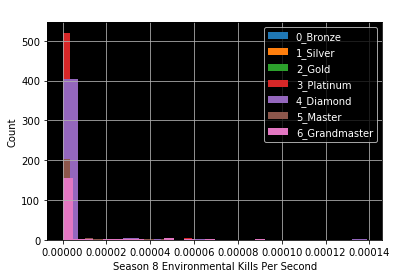

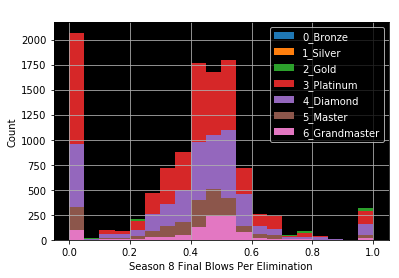

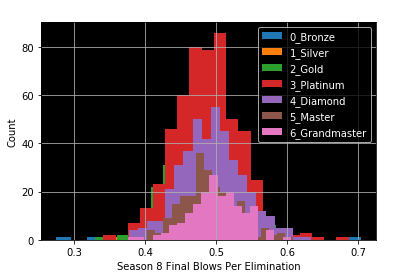

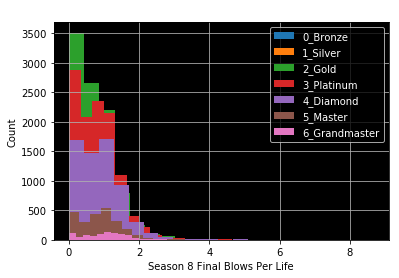

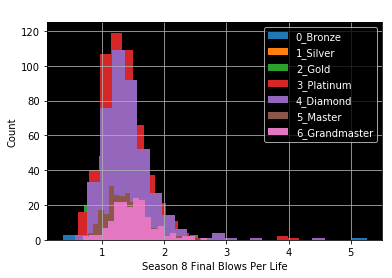

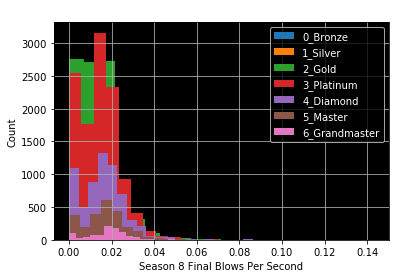

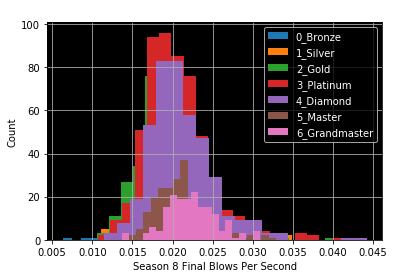

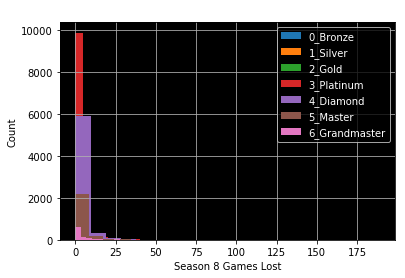

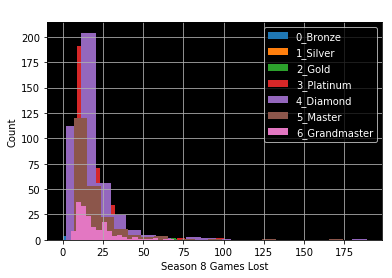

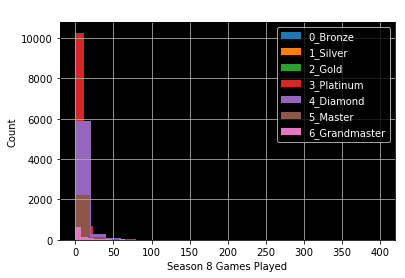

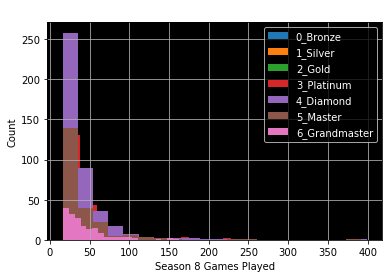

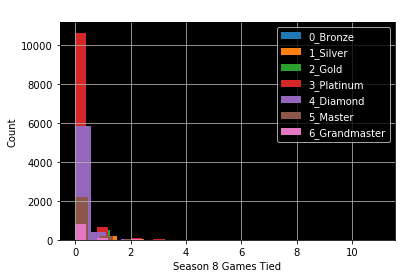

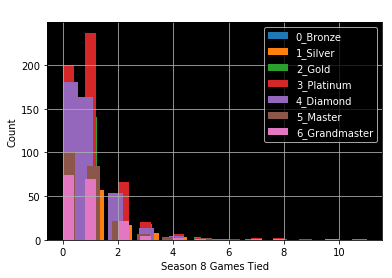

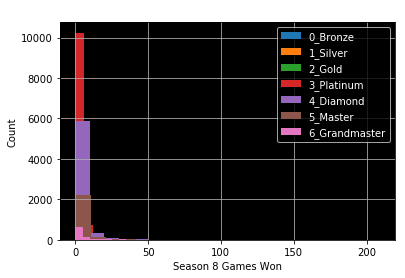

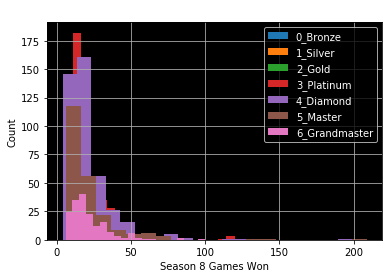

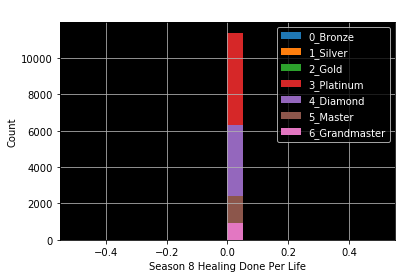

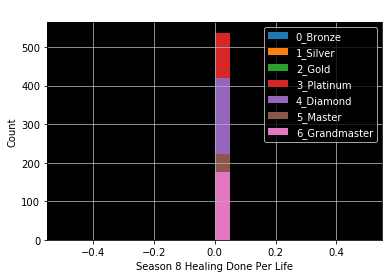

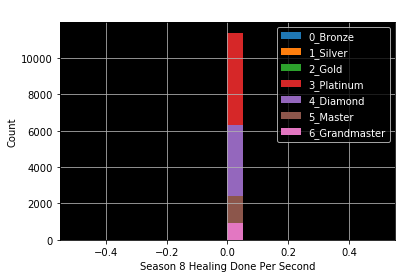

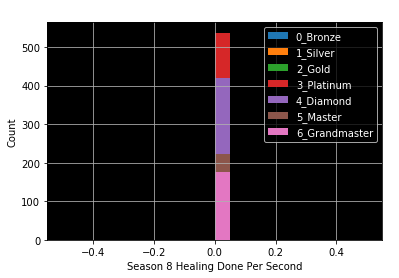

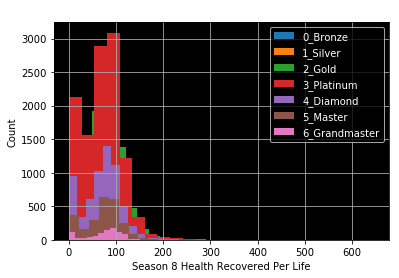

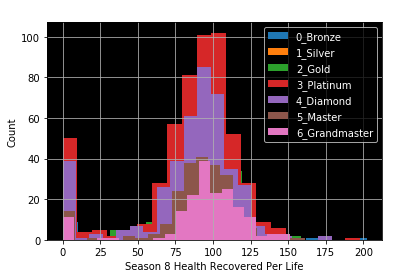

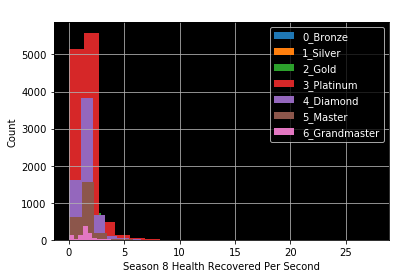

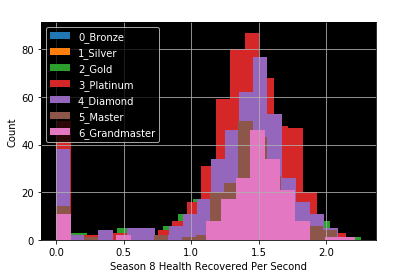

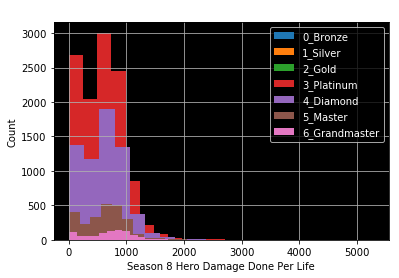

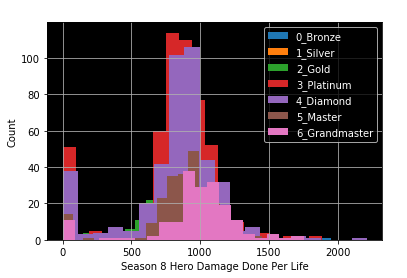

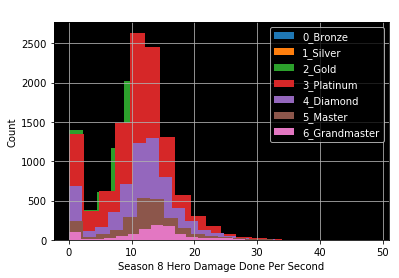

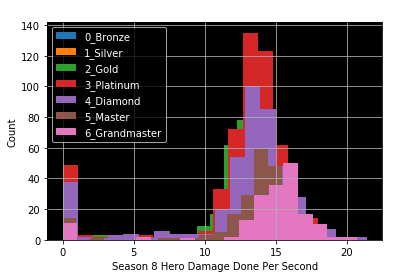

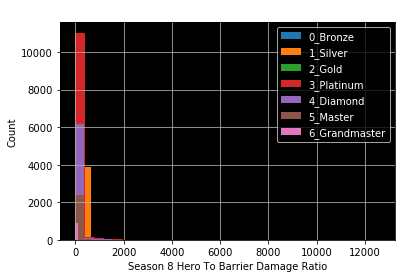

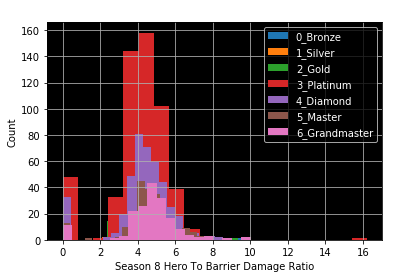

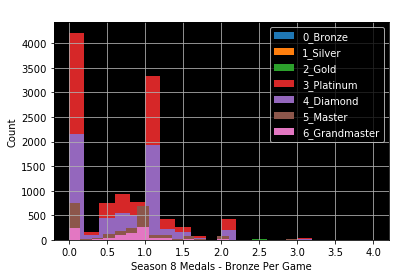

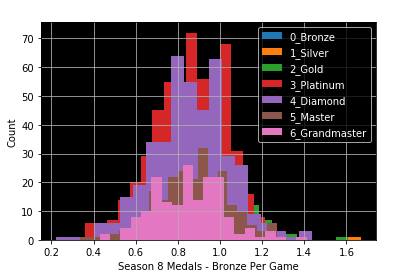

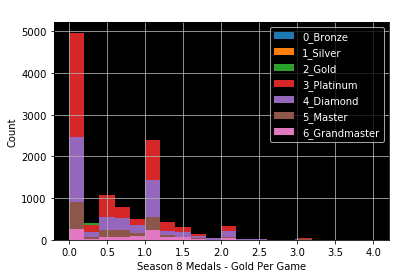

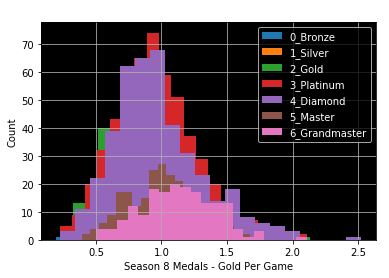

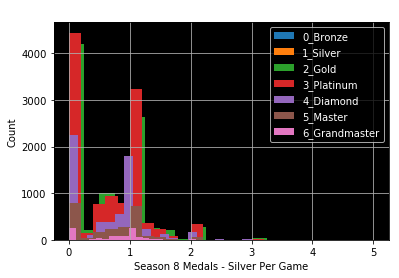

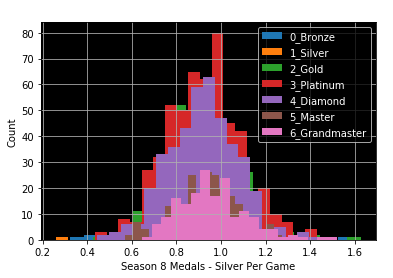

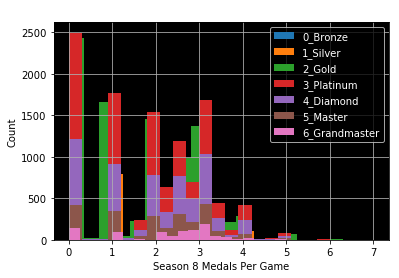

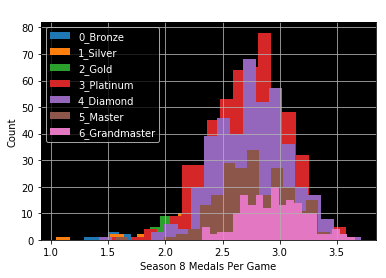

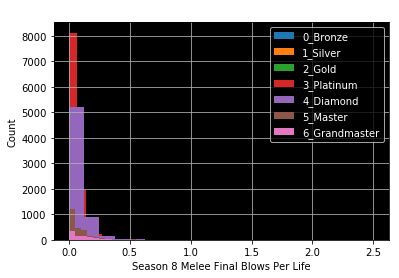

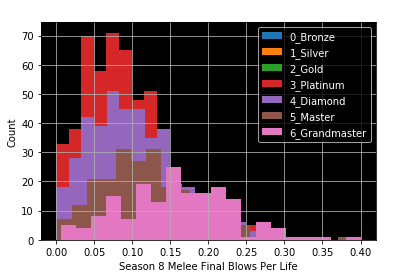

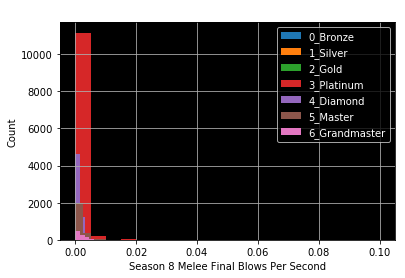

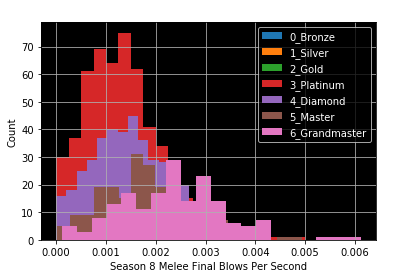

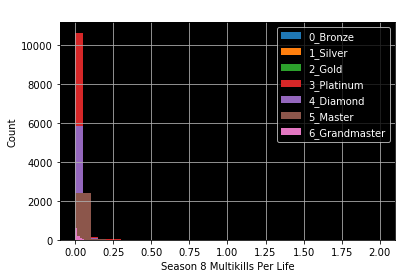

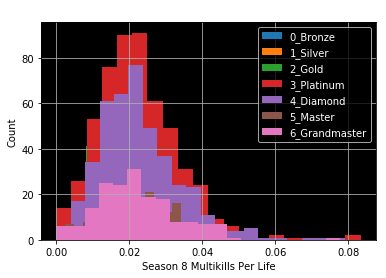

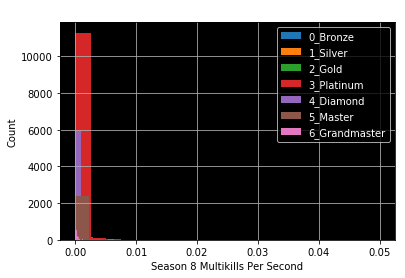

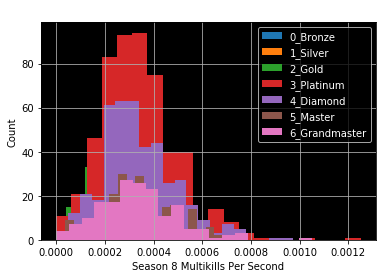

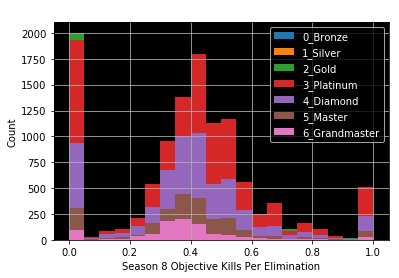

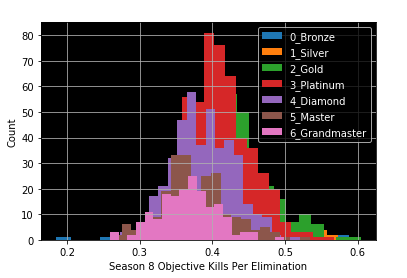

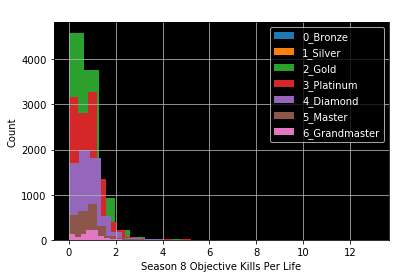

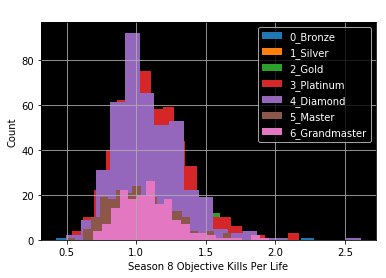

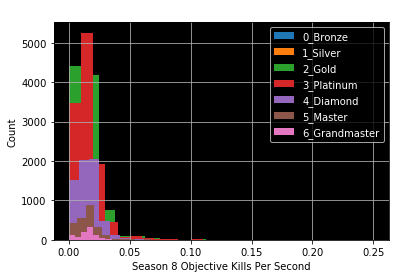

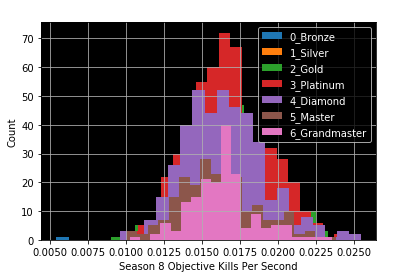

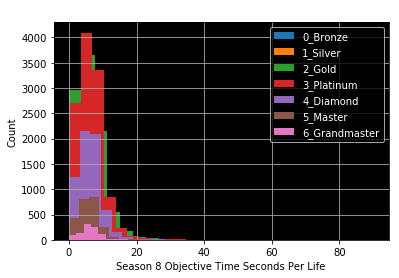

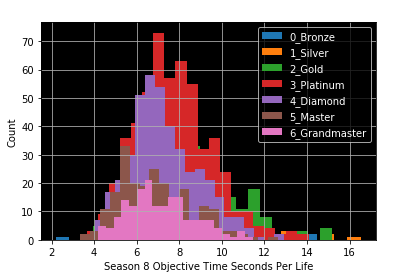

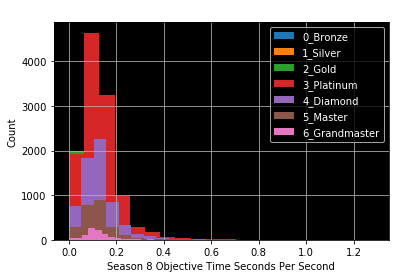

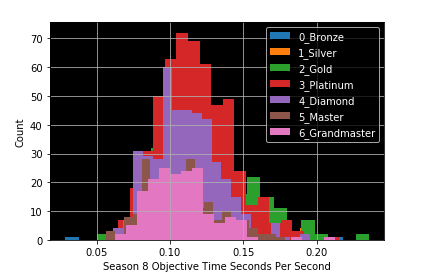

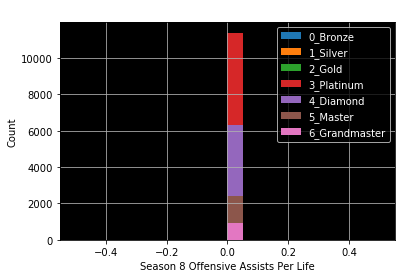

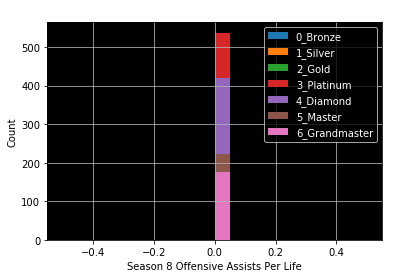

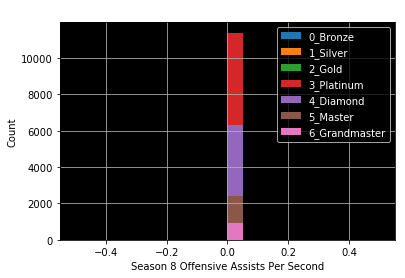

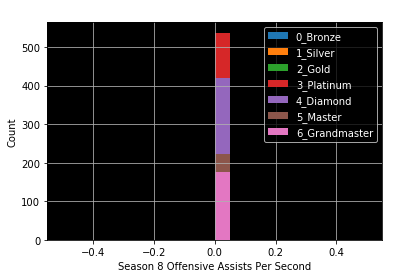

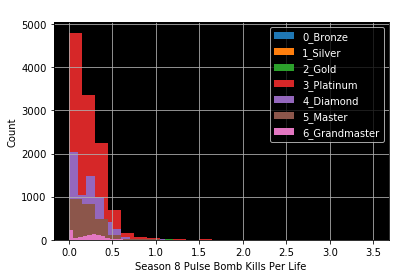

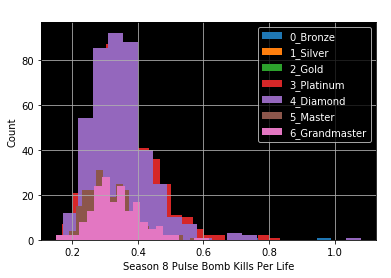

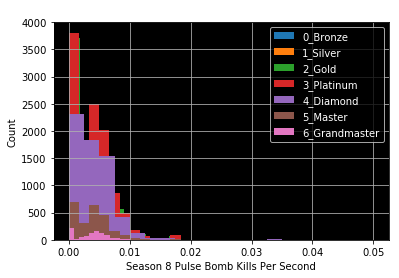

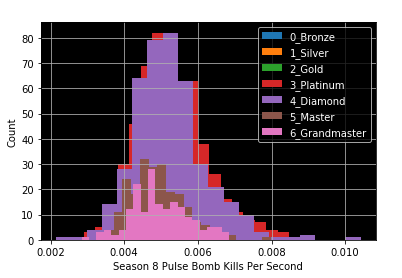

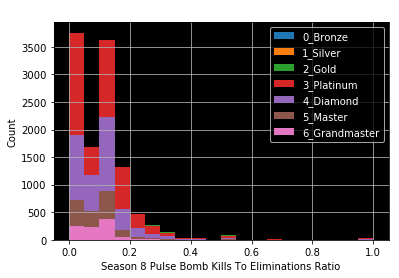

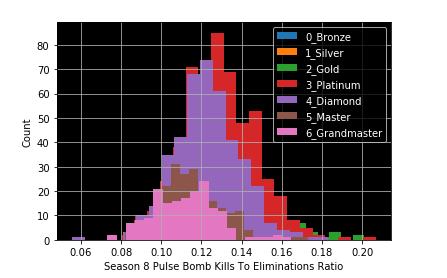

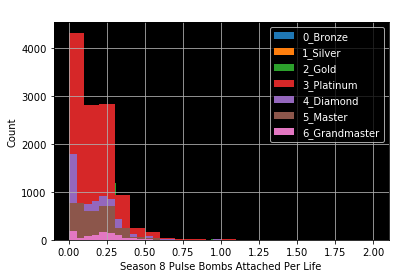

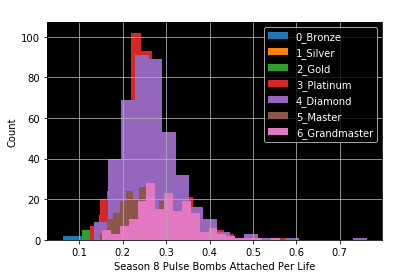

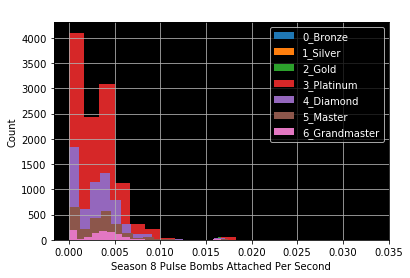

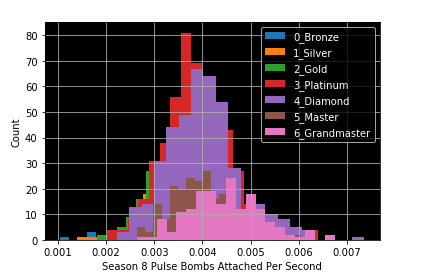

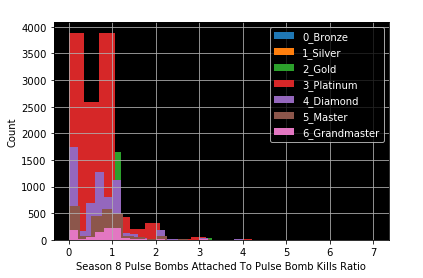

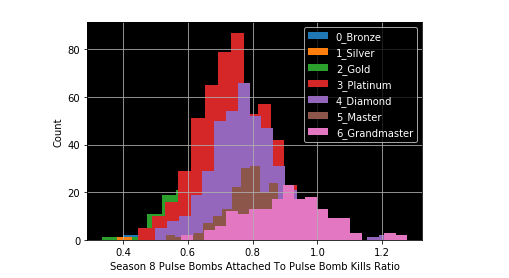

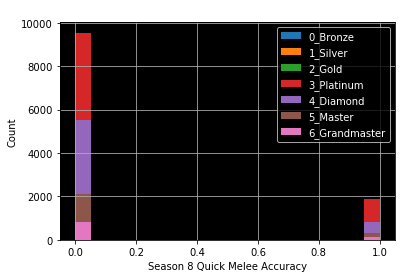

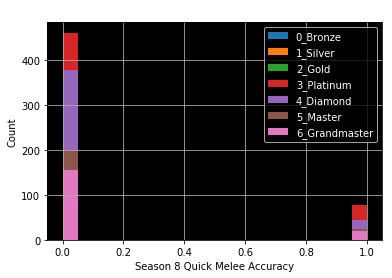

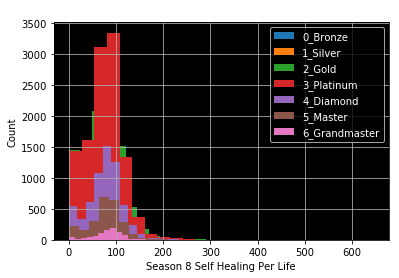

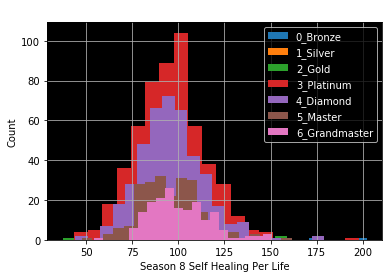

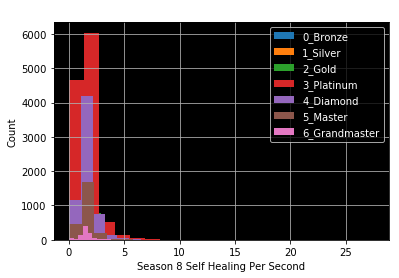

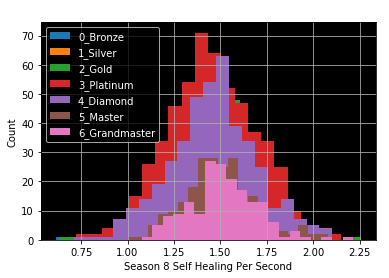

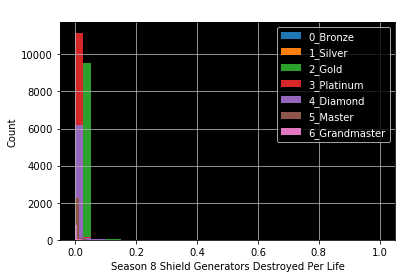

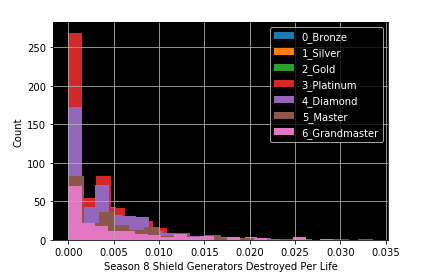

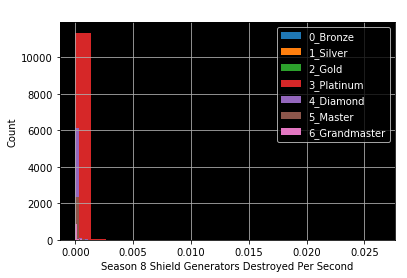

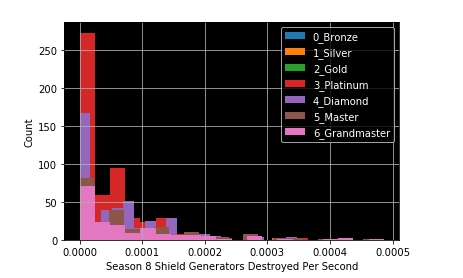

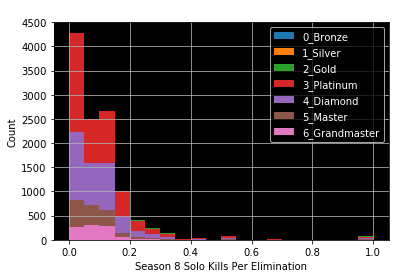

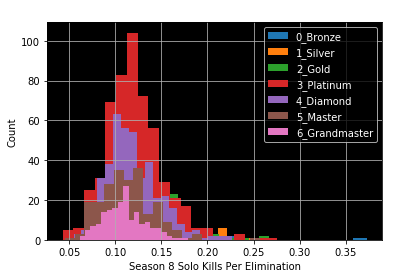

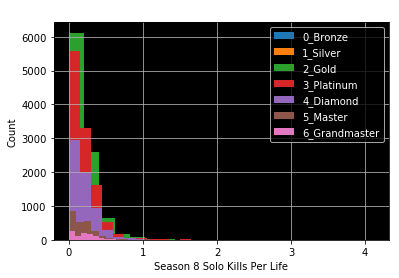

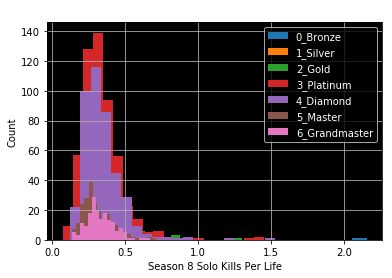

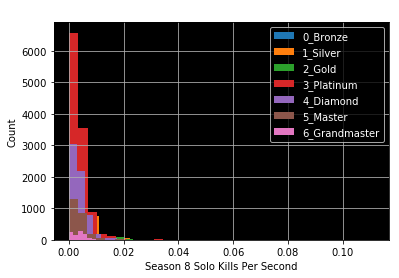

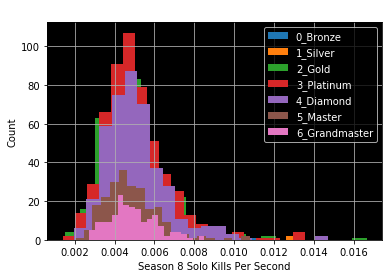

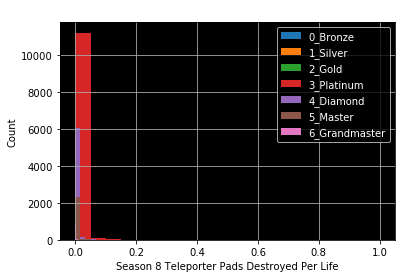

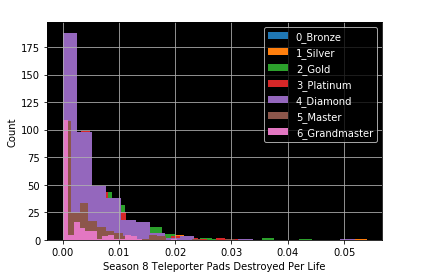

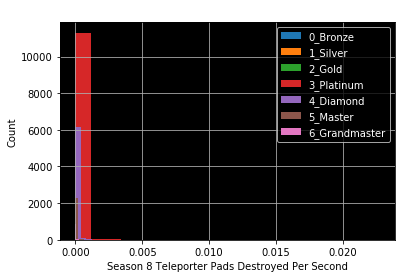

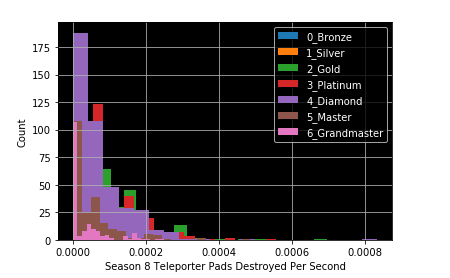

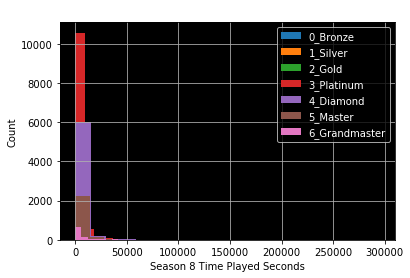

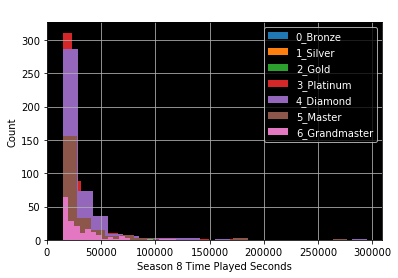

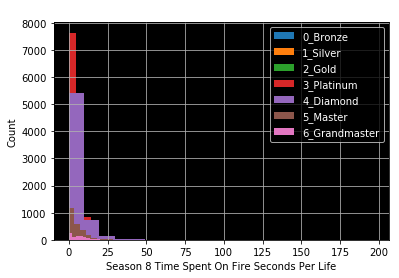

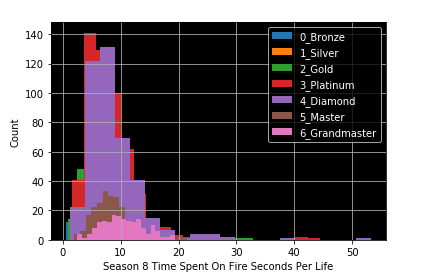

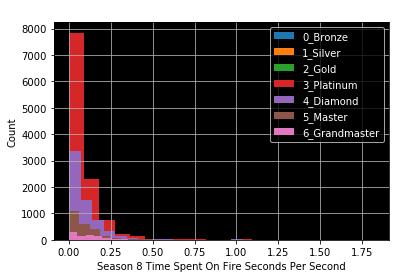

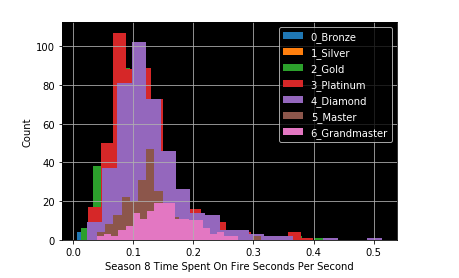

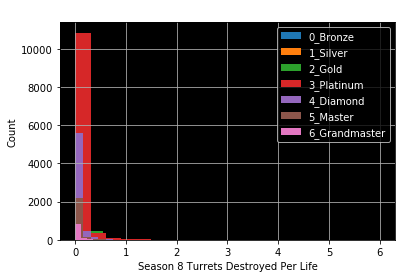

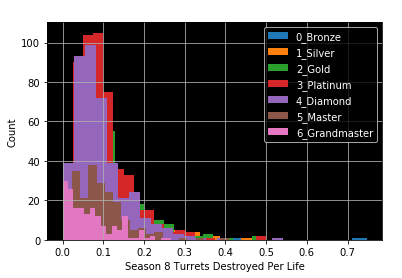

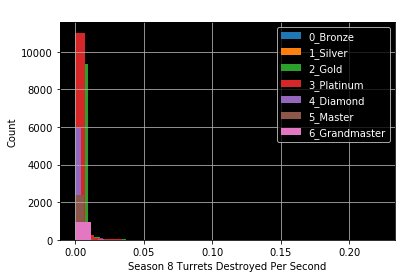

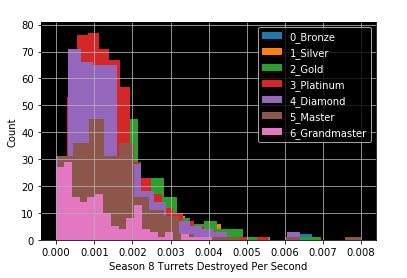

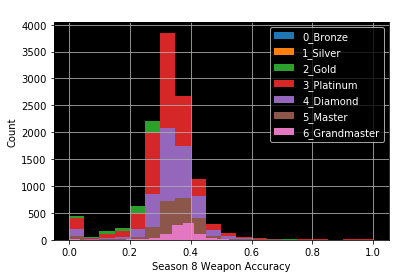

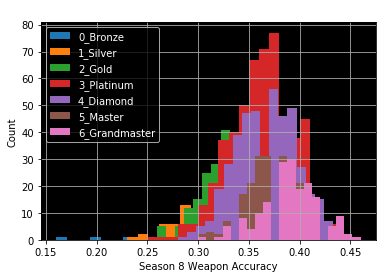

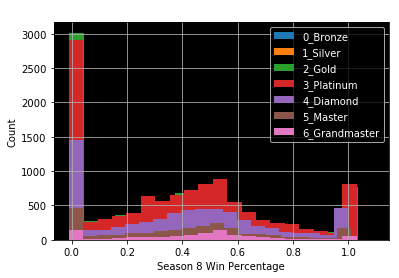

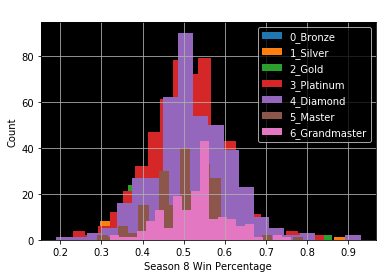

In [156]:
#Graph each
for k in fs:
    plot_hero_sr_feature_distribution("tracer", valid_criteria=valid_time, feature=k, mode="hist")

## Features and targets
The target class is SR. In the below code snippet the targets are separated away from the original dataset, where the remaining data acts as the features.

In [157]:
data = {}
#Itreate over raw and processed databases
for i in db_data:
    data[i] = {}
    #Iterate over heroes
    for j in db_data[i]:
        data[i][j] = {}
        #Create target dataframe (note mapping SR values to classes)
        data[i][j]["targets"] = pd.DataFrame(db_data[i][j]["SR"].map(get_rank))
        #Create features by dropping battletag and target columns
        data[i][j]["features"] = db_data[i][j].drop(["battletag", "SR"], axis=1)

However, the above contains data for *any* player who's played a certain hero. To obtain the filtered data, drop any entries with less than 3600 seconds played.

In [158]:
all_data = {}
valid_data = {}
#Itreate over raw and processed databases
for i in db_data:
    all_data[i] = {}
    valid_data[i] = {}
    #Iterate over heroes
    for j in db_data[i]:
        all_data[i][j] = {}
        valid_data[i][j] = {}
        ij_data = db_data[i][j]
        #All data
        all_data[i][j]["targets"] = pd.DataFrame(ij_data["SR"].map(get_rank))
        all_data[i][j]["features"] = ij_data.drop(["battletag", "SR"], axis=1)
        #Valid data
        ij_data = ij_data[valid_time <= ij_data["time_played_seconds"]]
        valid_data[i][j]["targets"] = pd.DataFrame(ij_data["SR"].map(get_rank))
        valid_data[i][j]["features"] = ij_data.drop(["battletag", "SR"], axis=1)

In [159]:
#Valid tracers from database
tracers["SR"].head()

0     4037
3     3516
5     3522
12    3054
13    2887
Name: SR, dtype: int64

In [160]:
#Valid tracers from valid_data
valid_data["processed"]["tracer"]["targets"].head()

SR
16      4_Diamond
44     3_Platinum
60  6_Grandmaster
84     3_Platinum
86      4_Diamond

## Benchmark
Before performing any kind of feature transformation to optimize the data for learning agents, let's establish a benchmark. Currently, there are 7 classes, so uneducated guessing would yield an accuracy of roughly 14% (1 out of 7). Let's try to beat this by training a decision tree for the processed valid Tracer set. First, we'll split the data into training/testing sets.

The below variables will be used throughout the notebook.

In [161]:
#This will be used throughout the notebook
random_state = 0
test_size = 0.2

### GridSearch 

In [162]:
from time import time
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer

#Scorer used for evaluating grid search
f_balanced = make_scorer(fbeta_score, beta=0.5, average="macro")

def do_learning(features_train, features_test, targets_train, targets_test):
    """
    This function trains several learners given the train_test_split of a feature
    and target set. The results are returned in a list of dictionaries.
    """
    
    learner_tups = [
        ("Decision Tree", DecisionTreeClassifier(
            random_state=random_state,
            max_depth=5
        )),
        ("Random Forest", RandomForestClassifier(
            n_estimators=500,
            random_state=random_state,
            min_samples_leaf=5
        )),
        ("Logistic Regressor", LogisticRegression(
            penalty="l2",
            solver="newton-cg",
            multi_class="multinomial",
            max_iter=200,
            random_state=random_state
        )),
        ("Neural Network", MLPClassifier(
            hidden_layer_sizes=(32,32,32),#64,64,64
            activation="tanh",
            solver="adam",
            learning_rate_init=0.0001,
            max_iter=5000,
            momentum=0.001,#0.01
            #early_stopping=True,
            random_state=random_state
        ))
    ]
    
    results = []
    #For each learner
    for i in range(len(learner_tups)):
        #Current learner and parameters
        result = {
            "name": learner_tups[i][0]
        }
        #Fit
        start = time()
        clf = learner_tups[i][1]
        clf.fit(features_train, targets_train)
        result["clf"] = clf
        result["time_fit"] = time() - start
        #Predict
        start = time()
        result["preds_train"] = clf.predict(features_train)
        result["preds_test"] = clf.predict(features_test)
        result["time_predict"] = time() - start
        #Metrics
        result["accuracy_train"] = accuracy_score(targets_train, result["preds_train"])
        result["accuracy_test"] = accuracy_score(targets_test, result["preds_test"])
        result["fbeta_train"] = fbeta_score(targets_train, result["preds_train"], beta=0.5, average="macro")
        result["fbeta_test"] = fbeta_score(targets_test, result["preds_test"], beta=0.5, average="macro")
        #Store results
        results.append(result)
    return results

### Testing the valid data set
Below we will test the valid dataset with the grid search implementation above. Note that the dataset is being split into 2 different sets for training and testing. The training set will be passed into the grid search, where it will then be split again into grid search's training and validation sets for k-fold cross validation. However, the grid serach will never see the testing set. The testing set will then be used to evaluate the grid search's performance.

In [163]:
#Train test split
from sklearn.model_selection import train_test_split

def evaluate_learning(dataset):
    """
    This method will do the following:
    1. Split the dataset into training and testing sets
    2. Request data to be fit to supervised learners
    3. Output results from fitting
    The learning results are returned.
    """
    #Split data
    features_train, features_test, targets_train, targets_test = train_test_split(
        dataset["features"],
        dataset["targets"]["SR"],
        test_size=test_size,
        random_state=random_state
    )
    
    #Do learning
    results = do_learning(features_train, features_test, targets_train, targets_test)
    
    #Output results
    for i in range(len(results)):
        result = results[i]
        print("==={}===".format(result["name"]))
        result_keys = sorted(result.keys())
        for j in range(len(result_keys)):
            #If not the predictions or learner objects
            if not (result_keys[j].startswith("preds") or result_keys[j].startswith("clf")):
                print("{}: {}".format(result_keys[j], result[result_keys[j]]))
        print("")
        
    #Return results (with train/test splits)
    return (results, [features_train, features_test, targets_train, targets_test])

#Tracer benchmark
valid_tracer_learning = evaluate_learning(valid_data["processed"]["tracer"])
valid_tracer_clfs = valid_tracer_learning[0]
valid_tracer_data_splits = valid_tracer_learning[1]

===Decision Tree===
accuracy_test: 0.364361702128
accuracy_train: 0.437125748503
fbeta_test: 0.321687274587
fbeta_train: 0.506546395212
name: Decision Tree
time_fit: 0.0250000953674
time_predict: 0.000999927520752

===Random Forest===
accuracy_test: 0.380319148936
accuracy_train: 0.953426480373
fbeta_test: 0.333960205931
fbeta_train: 0.941059674496
name: Random Forest
time_fit: 2.29999995232
time_predict: 0.139000177383

===Logistic Regressor===
accuracy_test: 0.377659574468
accuracy_train: 0.423153692615
fbeta_test: 0.426919052352
fbeta_train: 0.437743236538
name: Logistic Regressor
time_fit: 3.04999995232
time_predict: 0.000999927520752

===Neural Network===
accuracy_test: 0.279255319149
accuracy_train: 0.28875582169
fbeta_test: 0.0467289719626
fbeta_train: 0.0538859094884
name: Neural Network
time_fit: 0.421000003815
time_predict: 0.00200009346008



### Confusion matrix
Below is the confusion matrix to more clearly visualize the benchmark's performance.

In [164]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(
    targets_list,
    predictions_list,
    target_keys,
    titles_list,
    normalize=True,
    cmap=plt.cm.Blues):
    """
    Plots a confusion matrix. Original code from
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    np.set_printoptions(precision=2)
    #For each classifier
    for i in range(len(titles_list)):
        titles = titles_list[i]
        #For each of train/test set
        for ii in range(len(titles)):
            #Get confusion matrix
            confusion = confusion_matrix(targets_list[ii], predictions_list[i][ii])

            #Normalize if necessary
            if normalize:
                confusion = confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
                #print("Normalized confusion matrix")
            #else:
                #print("Unnormalized confusion matrix")
            #print(confusion)

            #Plot
            plt.figure()

            #Styling
            plt.imshow(confusion, interpolation="nearest", cmap=cmap)
            plt.title(titles[ii])
            plt.colorbar()
            tick_marks = np.arange(len(target_keys))
            plt.xticks(tick_marks, target_keys, rotation=45)
            plt.yticks(tick_marks, target_keys)
            #Data entry
            fmt = ".2f" if normalize else "d"
            thresh = confusion.max() / 2
            for j,k in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
                plt.text(k, j, format(confusion[j,k], fmt),
                        horizontalalignment="center",
                        color="black" if confusion[j,k] <= thresh else "white")
            #Labels
            plt.tight_layout()
            plt.ylabel("Actual")
            plt.xlabel("Predicted")

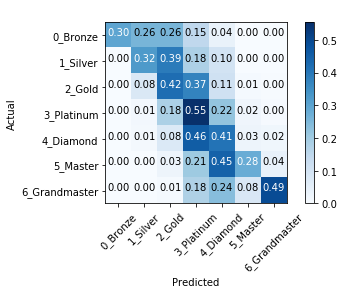

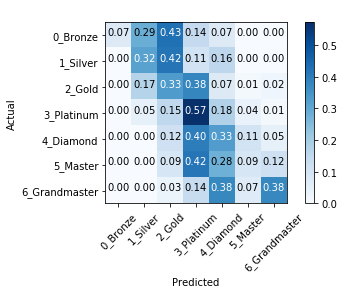

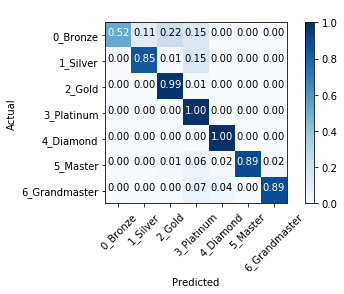

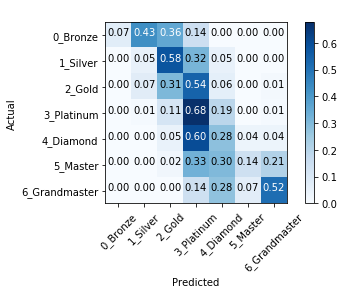

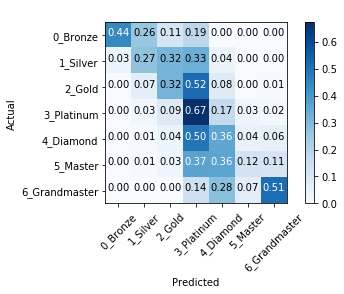

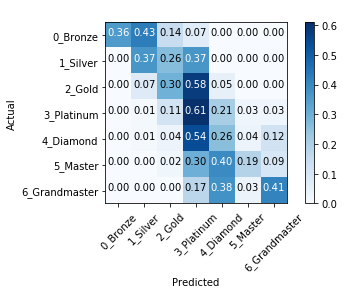

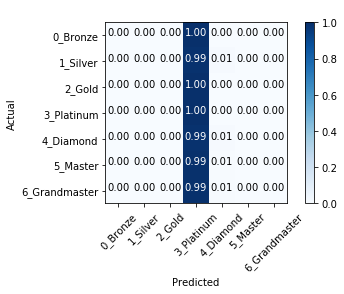

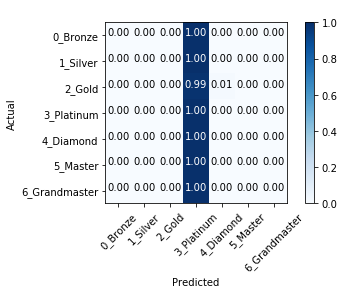

In [165]:
def get_all_confusion_matrices(results, train_targets, test_targets):
    #These lists will be passed to the plot confusion matrix function
    predictions_list = []
    titles_list = []
    #For each classifier result
    for i in range(len(results)):
        #Append predictions
        predictions_list.append([
            results[i]["preds_train"],
            results[i]["preds_test"]
        ])
        #Append titles
        titles_list.append([
            results[i]["name"] + " | Train",
            results[i]["name"] + " | Test"
        ])
    #Get targets for train and test
    targets_list = [train_targets, test_targets]
    #Plot all matrices
    plot_confusion_matrices(
        targets_list,
        predictions_list,
        sorted(sr_map.keys()),
        titles_list
    )

#Valid tracer benchmark
get_all_confusion_matrices(valid_tracer_clfs, valid_tracer_data_splits[2], valid_tracer_data_splits[3])

### Analysis
In order to improve testing accuracy, the following steps will be taken:
* Outlier removal
    * Features with 
* Feature elimination
    * It's possible that some features have no impact on the data. We can investigate the feature distribution and eliminate non-essential features which increase dimensionality with minimal benefit.
    * Feature transformation
* Features with a highly skewed distribution can negatively impact learning. To avoid this, such features will undergo log transformation.
    * Features like weapon accuracy are bound within range [0,1], whereas features like damage per seconod have a lower bound of 0 but are unbounded above. To ensure each feature is weighted the same in the eyes of future learners, minmax scaling to [0,1] will be implemented on unbounded features.
    * PCA will be implemented in an attempt to discover which features are responsible for the most variance in the dataset. Discovered features explaining a certain amount of variance in the data will be used to train a new set of learners.

## Improving the benchmark
To start, let's remove any possible outliers from the dataset. Outlier detection will be determined via the [z-score method](http://colingorrie.github.io/outlier-detection.html). For each hero, each feature will be analyzed. If any feature lies outside of 3 standard deviations from the feature's mean, the entire entry will be dropped.

In [166]:
outlier_lim = 3
inlier_data = {}
#Please note this 5 level deep loop structure is disgusting. However, it's efficient for
#removing outliers from each SR class

#For each of raw and processed
for i in valid_data:
    inlier_data[i] = {}
    #For each hero
    for j in valid_data[i]:
        inlier_data[i][j] = {}
        
        #Get old data
        ij_data = valid_data[i][j]
        #Dictionary to contain all outlier indices to drop
        to_drop = {}
        
        #For each rank
        for sr in sr_map:
            #Get indices for SR level targets
            sr_targets = ij_data["targets"][sr == ij_data["targets"]["SR"]]
            sr_indices = sr_targets.index
            #Get features for corresponding SR entries
            sr_features = ij_data["features"].loc[sr_indices]
            
            #Iterate over each over each feature
            for k in sr_features.columns.values:
                #Get indices of outliers outside of 3 standard deviations
                outliers = sr_features[np.abs(sr_features[k] - sr_features[k].mean()) > outlier_lim * sr_features[k].std()].index
                #Keep track of each outlier index
                for l in range(len(outliers)):
                    to_drop[outliers[l]] = 1
                    
        #Drop outlier indices
        inlier_data[i][j]["features"] = valid_data[i][j]["features"].drop(to_drop.keys(), axis=0)
        inlier_data[i][j]["targets"] = valid_data[i][j]["targets"].drop(to_drop.keys(), axis=0)

===Decision Tree===
accuracy_test: 0.33110367893
accuracy_train: 0.490802675585
fbeta_test: 0.297667520806
fbeta_train: 0.521328758801
name: Decision Tree
time_fit: 0.0209999084473
time_predict: 0.000999927520752

===Random Forest===
accuracy_test: 0.43143812709
accuracy_train: 0.955685618729
fbeta_test: 0.445224142803
fbeta_train: 0.938866532296
name: Random Forest
time_fit: 1.83000016212
time_predict: 0.110999822617

===Logistic Regressor===
accuracy_test: 0.387959866221
accuracy_train: 0.464046822742
fbeta_test: 0.453068219875
fbeta_train: 0.489338005117
name: Logistic Regressor
time_fit: 2.95300006866
time_predict: 0.0

===Neural Network===
accuracy_test: 0.304347826087
accuracy_train: 0.288461538462
fbeta_test: 0.0505050505051
fbeta_train: 0.0480461242793
name: Neural Network
time_fit: 0.389999866486
time_predict: 0.00300002098083



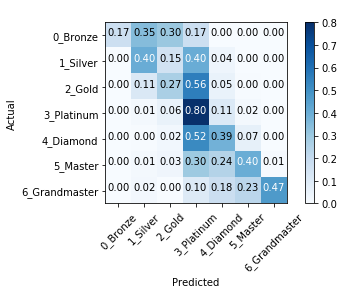

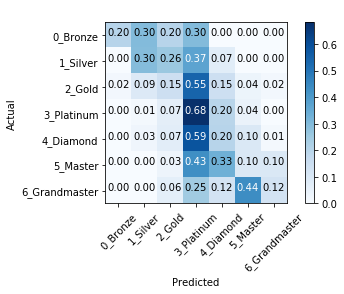

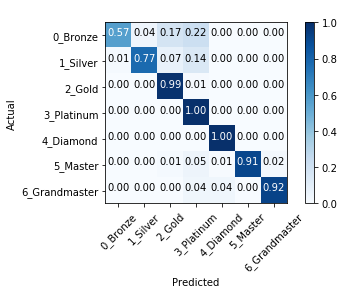

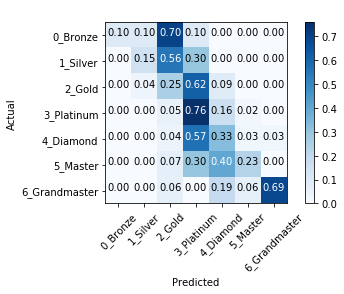

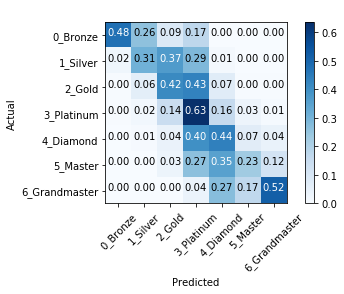

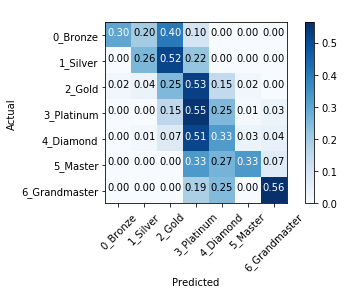

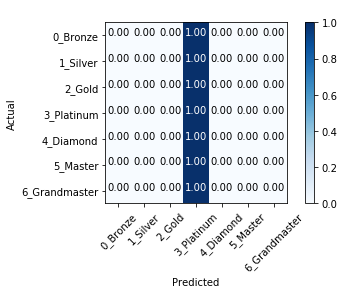

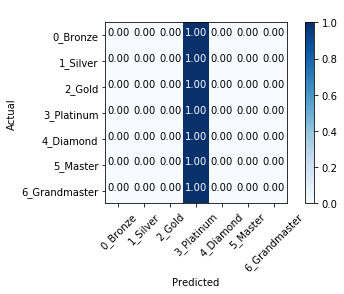

In [167]:
#Investigate outlier findings
inlier_tracer_learning = evaluate_learning(inlier_data["processed"]["tracer"])
inlier_tracer_clfs = inlier_tracer_learning[0]
inlier_tracer_data_splits = inlier_tracer_learning[1]
get_all_confusion_matrices(inlier_tracer_clfs, inlier_tracer_data_splits[2], inlier_tracer_data_splits[3])

### Transforming features
SciPy provides several functions to analyze the skewness of a distribution. Using [skew()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html), a normally distributed feature would return a skewness close to 0. The magnitude of the feature (not the direction) will be the deciding factor on whether or not a feature for a specific hero will be logistically scaled. Specifically, any feature whose distribution returns a skewness exceeding 1.5 will undero logistic scaling.

Furthermore, we'll take this time to minmax scale all numerical features (which is the entire feature set).

In [168]:
from scipy.stats import skew, skewtest
from sklearn.preprocessing import MinMaxScaler

#Initialize scaler
scaler = MinMaxScaler(feature_range=(0,1))
skew_thresh = 1.5

scaled_data = {}
#Itreate over raw and processed databases
for i in inlier_data:
    scaled_data[i] = {}
    #Iterate over heroes
    for j in inlier_data[i]:
        scaled_data[i][j] = {}
        ij_data = inlier_data[i][j]
        #Targets
        scaled_data[i][j]["targets"] = ij_data["targets"].copy(deep=True)
        
        #Features
        scaled_data[i][j]["features"] = ij_data["features"].copy(deep=True)
        
        #Logistic scale for skewed features
        #Iterate over features
        features = scaled_data[i][j]["features"]
        for k in features:
            #If exceeds skew threshold
            if 1.5 < abs(skew(features[k])):
                #Log scale         
                features[k] = features[k].apply(lambda x: np.log(x + 1))
        
        #Get column names for numerics (all features)
        feature_names = list(features.columns.values)
        #MinMax scale
        features[feature_names] = scaler.fit_transform(features[feature_names])

Below are the same distributions plotted for Tracer previously. However, these distributions have now been minmax scaled throughout and logistically scaled whenever a feature's skew value exceeded 1.5 in magnitude.

In [169]:
#graph_feature_distributions(scaled_data["processed"]["tracer"]["features"])

### Learning from the scaled data
Let's see if the learners can improveat all from scaling.

===Decision Tree===
accuracy_test: 0.33110367893
accuracy_train: 0.490802675585
fbeta_test: 0.297667520806
fbeta_train: 0.521328758801
name: Decision Tree
time_fit: 0.0199999809265
time_predict: 0.00100016593933

===Random Forest===
accuracy_test: 0.43143812709
accuracy_train: 0.954849498328
fbeta_test: 0.44554993155
fbeta_train: 0.93843026523
name: Random Forest
time_fit: 1.86099982262
time_predict: 0.111000061035

===Logistic Regressor===
accuracy_test: 0.42474916388
accuracy_train: 0.510033444816
fbeta_test: 0.435070646299
fbeta_train: 0.516180723351
name: Logistic Regressor
time_fit: 0.0880000591278
time_predict: 0.000999927520752

===Neural Network===
accuracy_test: 0.451505016722
accuracy_train: 0.509197324415
fbeta_test: 0.410161121756
fbeta_train: 0.495471859904
name: Neural Network
time_fit: 3.10599994659
time_predict: 0.00300002098083



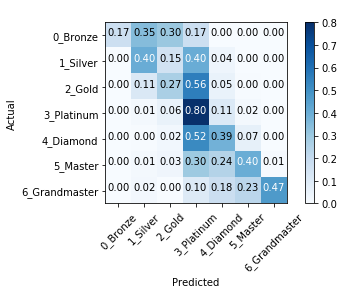

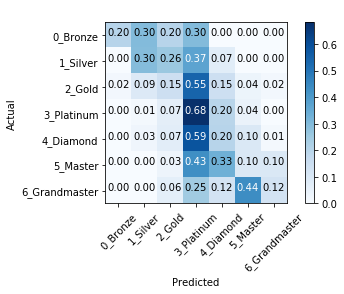

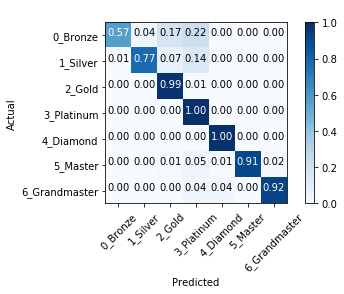

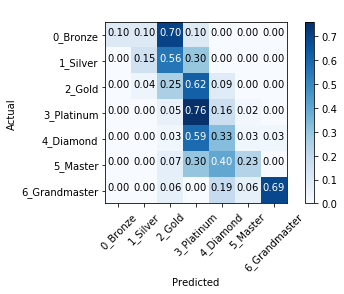

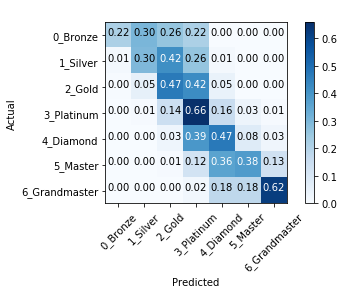

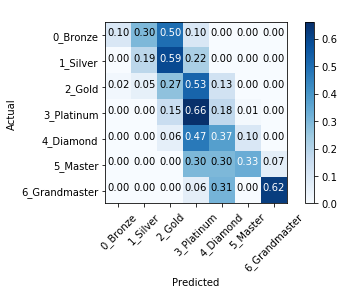

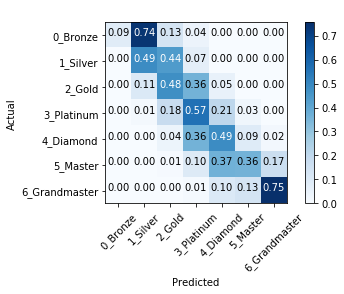

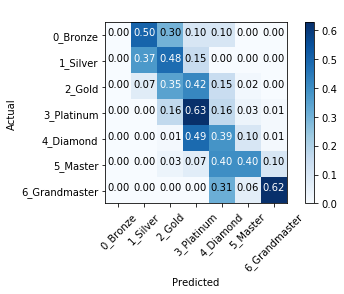

In [170]:
#Investigate scaled data findings
scaled_tracer_learning = evaluate_learning(scaled_data["processed"]["tracer"])
scaled_tracer_clfs = scaled_tracer_learning[0]
scaled_tracer_data_splits = scaled_tracer_learning[1]
get_all_confusion_matrices(scaled_tracer_clfs, scaled_tracer_data_splits[2], scaled_tracer_data_splits[3])

### Scaled analysis and feature removal
It doesn't seem as though the scaling of the data had a positive impact for most of the classifiers. In fact, some actually perform worse with respect to accuracy and fbeta score. Investigating the data further, we see that there are some running sum features in the dataset. Specifically, time played, games played, and deaths all contain no average information. Let's see if removing these will provide better learning performance by decreasing noise, and note that with exception of time played, these features should be removed anyway. Deaths as a standing total will grow the more a player plays. The same argument could be made for games played/won/lost, although these statistics are accurately represented in win percentage.

In [171]:
scaled_dropped_data = {}
#Itreate over raw and processed databases
for i in scaled_data:
    scaled_dropped_data[i] = {}
    #Iterate over heroes
    for j in scaled_data[i]:
        scaled_dropped_data[i][j] = {}
        ij_data = scaled_data[i][j]
        #Targets
        scaled_dropped_data[i][j]["targets"] = ij_data["targets"].copy(deep=True)
        #Features
        scaled_dropped_data[i][j]["features"] = ij_data["features"].drop([
            "deaths", "games_lost", "games_played", "games_tied", "games_won", "time_played_seconds"
        ], axis=1)

In [172]:
len(scaled_data["processed"]["tracer"]["features"].keys()) - len(scaled_dropped_data["processed"]["tracer"]["features"].keys())

6

### Scaled dropped analysis
This change to the training/testing data, on average, at best performs just as good as the `scaled_data` set. Let's see if PCA can help reduce dimensionality.

In [173]:
from sklearn.decomposition import PCA

scaled_dropped_tracer = scaled_dropped_data["processed"]["tracer"]["features"]
pca = PCA(n_components=len(scaled_dropped_tracer.columns), random_state=random_state).fit(scaled_dropped_tracer)
pca.explained_variance_ratio_.cumsum()

array([ 0.2 ,  0.35,  0.43,  0.52,  0.59,  0.64,  0.69,  0.73,  0.76,
        0.79,  0.82,  0.84,  0.86,  0.88,  0.9 ,  0.91,  0.93,  0.94,
        0.95,  0.96,  0.97,  0.97,  0.98,  0.98,  0.99,  0.99,  0.99,
        1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ])

### Observing PCA explained variance
From the above output, it seems as though PCA can greatly reduce the dimensionality of the problem. Specifically, the first 25 components can explain 99% of variance. Let's try using these principle components with the learners.

In [174]:
pca_data = {}
#Itreate over raw and processed databases
for i in scaled_dropped_data:
    pca_data[i] = {}
    #Iterate over heroes
    for j in scaled_dropped_data[i]:
        pca_data[i][j] = {}
        ij_data = scaled_dropped_data[i][j]
        #Targets
        pca_data[i][j]["targets"] = ij_data["targets"].copy(deep=True)
        
        #PCA features
        #Identify how many features required for 80% explained variance
        reduced_data = PCA(n_components=.99, random_state=random_state).fit_transform(ij_data["features"])
        pca_data[i][j]["features"] = pd.DataFrame(data=reduced_data)
        pca_data[i][j]["features"].columns = ["Dimension {}".format(k) for k in range(len(pca_data[i][j]["features"].columns))]    

### PCA learning

===Decision Tree===
accuracy_test: 0.284280936455
accuracy_train: 0.439799331104
fbeta_test: 0.208823631143
fbeta_train: 0.439794814924
name: Decision Tree
time_fit: 0.0130000114441
time_predict: 0.00100016593933

===Random Forest===
accuracy_test: 0.384615384615
accuracy_train: 0.954849498328
fbeta_test: 0.340603327836
fbeta_train: 0.913359295524
name: Random Forest
time_fit: 1.73299980164
time_predict: 0.115000009537

===Logistic Regressor===
accuracy_test: 0.43143812709
accuracy_train: 0.501672240803
fbeta_test: 0.41855673602
fbeta_train: 0.528229637646
name: Logistic Regressor
time_fit: 0.0410001277924
time_predict: 0.000999927520752

===Neural Network===
accuracy_test: 0.458193979933
accuracy_train: 0.519230769231
fbeta_test: 0.414039180175
fbeta_train: 0.491573565489
name: Neural Network
time_fit: 2.62199997902
time_predict: 0.00300002098083



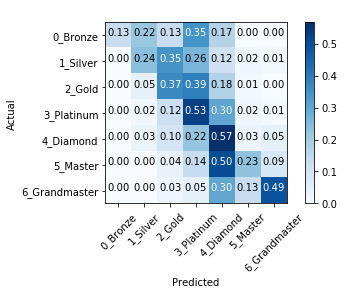

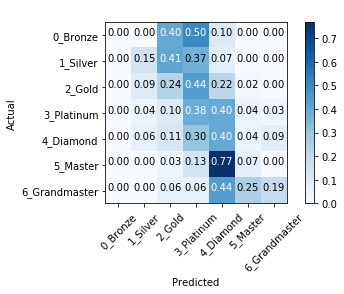

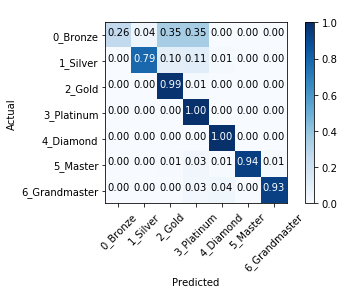

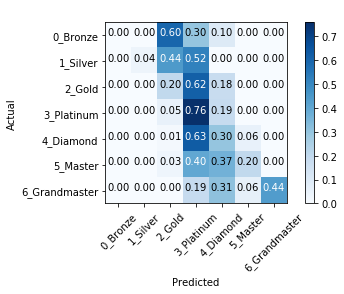

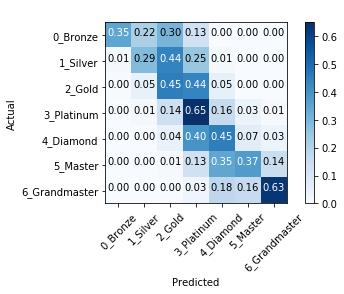

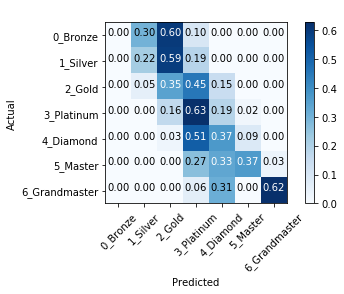

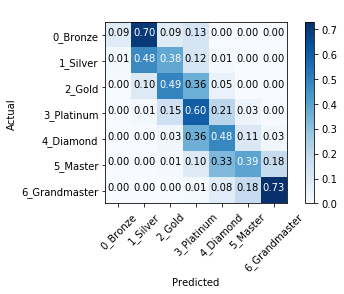

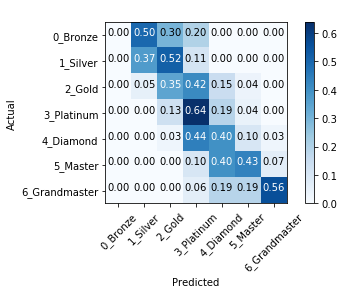

In [175]:
pca_tracer_learning = evaluate_learning(pca_data["processed"]["tracer"])
pca_tracer_clfs = pca_tracer_learning[0]
pca_tracer_data_splits = pca_tracer_learning[1]
get_all_confusion_matrices(pca_tracer_clfs, pca_tracer_data_splits[2], pca_tracer_data_splits[3])